# Setup

In [1]:

def imshow(tensor, renderer=None, xaxis="", yaxis="", font_size=None, show=True, color_continuous_midpoint=0.0, **kwargs):
    import plotly.express as px
    import transformer_lens.utils as utils
    fig = px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=color_continuous_midpoint, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs)
    if not font_size is None:
        if 'x' in kwargs:
            fig.update_layout(
              xaxis = dict(
                tickmode='array',
                tickvals = kwargs['x'],
                ticktext = kwargs['x'], 
                ),
               font=dict(size=font_size, color="black"))
        if 'y' in kwargs:
            fig.update_layout(
              yaxis = dict(
                tickmode='array',
                tickvals = kwargs['y'],
                ticktext = kwargs['y'], 
                ),
               font=dict(size=font_size, color="black"))
    plot_args = {
        'width': 800,
        'height': 600,
        "autosize": False,
        'showlegend': True,
        'margin': {"l":0,"r":0,"t":100,"b":0}
    }
    
    fig.update_layout(**plot_args)
    fig.update_layout(legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    ))
    if show:
        fig.show(renderer)
    else:
        return fig


# idea:
# do in higher precision because things are so smol


In [2]:
# requires
# pip install git+https://github.com/Phylliida/MambaLens.git

from mamba_lens import HookedMamba # this will take a little while to import
import torch
model_path = "state-spaces/mamba-370m"
model = HookedMamba.from_pretrained(model_path, device='cuda')
torch.set_grad_enabled(False)


/opt/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Moving model to device:  cuda


In [214]:

from acdc.data.ioi import ioi_data_generator, ABC_TEMPLATES, get_all_single_name_abc_patching_formats
from acdc.data.utils import generate_dataset

num_patching_pairs = 200
seed = 27
valid_seed = 28
constrain_to_answers = True
# this makes our data size 800, first 400 is each (a,b) pair, and then second 400 is each pair swapped to be (b,a)
has_symmetric_patching = True

from acdc.data.ioi import BABA_TEMPLATES
templates = ABC_TEMPLATES
patching_formats = list(get_all_single_name_abc_patching_formats())
PATCHING_FORMAT_I = 0
patching_formats = [patching_formats[PATCHING_FORMAT_I]]
print("using patching format")
print(patching_formats[0])

data = generate_dataset(model=model,
                  data_generator=ioi_data_generator,
                  num_patching_pairs=num_patching_pairs,
                  seed=seed,
                  valid_seed=valid_seed,
                  constrain_to_answers=constrain_to_answers,
                  has_symmetric_patching=has_symmetric_patching, 
                  varying_data_lengths=True,
                  templates=templates,
                  patching_formats=patching_formats)


import acdc.data.ioi
from collections import defaultdict
name_positions_map = defaultdict(lambda: [])
for template in templates:
    name = acdc.data.ioi.good_names[0]
    template_filled_in = template.replace("[NAME]", name)
    template_filled_in = template_filled_in.replace("[PLACE]", acdc.data.ioi.good_nouns['[PLACE]'][0])
    template_filled_in = template_filled_in.replace("[OBJECT]", acdc.data.ioi.good_nouns['[OBJECT]'][0])
    # get the token positions of the [NAME] in the prompt
    name_positions = tuple([(i) for (i,s) in enumerate(model.to_str_tokens(torch.tensor(model.tokenizer.encode(template_filled_in)))) if s == f' {name}'])
    name_positions_map[name_positions].append(template)
sorted_by_frequency = sorted(list(name_positions_map.items()), key=lambda x: -len(x[1]))
most_frequent_name_positions, templates = sorted_by_frequency[0]
print("using templates")
for template in templates:
    print(template)
print(f"with name positions {most_frequent_name_positions}")

data = generate_dataset(model=model,
              data_generator=ioi_data_generator,
              num_patching_pairs=num_patching_pairs,
              seed=seed,
              valid_seed=valid_seed,
              constrain_to_answers=constrain_to_answers,
              has_symmetric_patching=has_symmetric_patching, 
              varying_data_lengths=True,
              templates=templates,
              patching_formats=patching_formats)



using patching format
CAB AB C
DAB AB D
using templates
Then, [NAME], [NAME] and [NAME] went to the [PLACE]. [NAME] and [NAME] gave a [OBJECT] to
Afterwards [NAME], [NAME] and [NAME] went to the [PLACE]. [NAME] and [NAME] gave a [OBJECT] to
Friends [NAME], [NAME] and [NAME] went to the [PLACE]. [NAME] and [NAME] gave a [OBJECT] to
with name positions (2, 4, 6, 12, 14)


# Run Edge Attribution Patching with Integrated Gradients

In [191]:
# from tqdm import tqdm
from functools import partial
from jaxtyping import Float
from transformer_lens.hook_points import HookPoint
from mamba_lens.input_dependent_hooks import clean_hooks
from tqdm import tqdm
from einops import rearrange

model_kwargs = {
    'fast_ssm': False,
    'fast_conv': False
}
BATCH_SIZE = 10

# removes all hooks including "leftover" ones that might stick around due to interrupting the model at certain times
clean_hooks(model)

def normalized_logit_diff_metric(patched_logits, unpatched_logits, corrupted_logits, patched_correct, corrupted_correct, also_return_acc=False):
    B,V = patched_logits.size()

    #print(data.unpatched.logits.size(), data.patched.logits.size(), data.corrupted.logits.size())
    A_logits_unpatched = unpatched_logits[torch.arange(B), patched_correct]
    A_logits_patched = patched_logits[torch.arange(B), patched_correct]
    A_logits_corrupted = corrupted_logits[torch.arange(B), patched_correct]

    B_logits_unpatched = unpatched_logits[torch.arange(B), corrupted_correct]
    B_logits_patched = patched_logits[torch.arange(B), corrupted_correct]
    B_logits_corrupted = corrupted_logits[torch.arange(B), corrupted_correct]

    # A and B are two potential outputs
    # if A patched > B patched, we are correct
    # else we are incorrect

    # thus we could just return A_logits_patched - B_logits_patched

    # however it is useful to "normalize" these values

    # in the worst case, our patching causes us to act like corrupted, and our diff will be
    # A_logits_corrupted - B_logits_corrupted
    # this will result in a small, negative value
    
    # in the best case, our patching will do nothing (cause us to act like unpatched), and our diff will be
    # A_logits_unpatched - B_logits_unpatched
    # this will result in a large, positive value

    # thus we can treat those as the "min" and "max" and normalize accordingly
    
    min_diff = A_logits_corrupted - B_logits_corrupted
    max_diff = A_logits_unpatched - B_logits_unpatched

    # the abs ensures that if it's wrong we don't try and make it more wrong
    possible_range = torch.abs(max_diff-min_diff)
    possible_range[possible_range == 0] = 1.0 # prevent divide by zero
    
    diff = A_logits_patched - B_logits_patched
    
    normalized_diff = (diff-min_diff)/possible_range

    # as described, 1.0 corresponds to acting like unpatched,
    # and 0.0 corresponds to acting like corrupted
    res = torch.mean(normalized_diff)
    
    if also_return_acc:
        num_correct = A_logits_patched > B_logits_patched
        acc = torch.sum(num_correct)/B
        return res, acc
    else:
        return res


# there's a subtle bug if you aren't careful:
# consider what happens when we do edge attribution patching and patch every edge
# what we want to happen is that it's identical to corrupted
# however this is not what happens!
# Start with layer 0:
# layer 0 will be patched
#    we subtract uncorrupted embed and add corrupted embed
#    in other words, the embed input to layer 0 will be from the corrupted run
# this results in layer 0 having an output of corrupted, as desired
# now consider layer 1
#    subtract uncorrupted embed and add corrupted embed
#      this is fine and results in embed input to layer 1 of corrupted
#    subtract uncorrupted layer 0 and add corrupted layer 0
#      layer 0 is already corrupted, so this has the effect of the output of layer 0 being
#          2*corrupted layer 0 - uncorrupted layer 0
#          this is not the same as corrupted!

# two ways to fix this:
# 1. fetch stored layer_input from uncorrupted run, and use that instead of the layer_input given in fwd_diff
#   this works, but then the gradients won't propogate properly (maybe? todo: test)
# 2. mark which edges are patched and don't "double patch" them
#   if we are patching all edges, this means that we simply apply only the embed diff to all layers,
#   as that'll result in all layers being patched
# 3. just subtract the outputs in the same forward pass, instead of a cached "unpatched" run
#  we do 3

global alpha
alpha = 1

def cache_output_hook( # hook_layer_output
    layer_output : Float[torch.Tensor, "B L D"],
    hook : HookPoint,
    layer : int,
    cached_outputs : Float[torch.Tensor, "NLayers+1 B L D"]):
    global alpha
    cached_outputs[layer+1] = layer_output
    return layer_output

def fwd_diff_hook( # hook_layer_input
    layer_input : Float[torch.Tensor, "B L D"],
    hook : HookPoint,
    layer : int,
    cached_outputs : Float[torch.Tensor, "NLayers+1 B L D"],
    corrupted_outputs : Float[torch.Tensor, "NLayers+1 B L D"]):
    global alpha
    return layer_input + (-cached_outputs[:layer+1]+corrupted_outputs[:layer+1]).sum(dim=0)*alpha

def bwd_diff_hook( # hook_layer_input
    grad : Float[torch.Tensor, "B L D"],
    hook: HookPoint,
    layer : int,
    batch_start: int,
    batch_end: int,
    cached_outputs : Float[torch.Tensor, "NLayers+1 B L D"],
    corrupted_outputs : Float[torch.Tensor, "NLayers+1 B L D"]):
    #print(f"running bwd with alpha {alpha} and layer {layer}") 
    
    # [N_upstream, B, L, D]
    upstream_diffs = (-cached_outputs[:layer+1]+corrupted_outputs[:layer+1])
    # grad is [B,L,D]

    # to do a taylor approximation of metric with respect to diff_0, we
    # multiply diffs and grad, then
    # sum over the L and D dimensions (this is doing a dot product of vectors of size L*D)
    # now we have attr of size [N_upstream, B, L]
    attr = (grad*upstream_diffs).sum(dim=-1)
    # [B, N_upstream, L]           [N_upstream, B, L]
    attr         =   torch.transpose(attr, 0, 1)
    # [B, N_upstream, L]
    attr = attr.clone().detach()
    if POSITIONS:
        attributions[batch_start:batch_end,:layer+1,layer+1] += attr
    else:
        #[B, N_upstream]
        attr = attr.sum(dim=-1)
        attributions[batch_start:batch_end,:layer+1,layer+1] += attr



def cache_conv_hook(
    conv_input: Float[torch.Tensor, "B L E"],
    hook: HookPoint,
    layer: int,
    cached_conv_inputs : Float[torch.Tensor, "NLayers B L E"]):
    cached_conv_inputs.append(conv_input)
    return conv_input

# for each conv slice,
# we have 
global filter_terms
def conv_patching_hook(
    conv_output: Float[torch.Tensor, "B L E"],
    hook: HookPoint,
    layer: int,
    cached_conv_inputs : Float[torch.Tensor, "NLayers B L E"],
    corrupted_conv_inputs : Float[torch.Tensor, "NLayers B L E"],
    slice_terms : [],
) -> Float[torch.Tensor, "B L E"]:
    ### This is identical to what the conv is doing
    # but we break it apart so we can patch on individual slices

    # we have two input hooks, the second one is the one we want
    D_CONV = model.cfg.d_conv

    # [E,1,D_CONV]
    conv_weight = model.blocks[layer].conv1d.weight
    # [E]
    conv_bias = model.blocks[layer].conv1d.bias
    uncorrupted_input = rearrange(cached_conv_inputs[layer], 'B L E -> B E L')
    corrupted_input = rearrange(corrupted_conv_inputs[layer], 'B L E -> B E L')
    B,E,L = uncorrupted_input.size()
    uncorrupted_input = torch.nn.functional.pad(uncorrupted_input, (D_CONV-1,0), mode='constant', value=0)
    corrupted_input = torch.nn.functional.pad(corrupted_input, (D_CONV-1,0), mode='constant', value=0)
    #print(uncorrupted_input.size(), corrupted_input.size())
    # we want some "patch hook" thing that uses autodiff or somethin
    output = torch.zeros([B,E,L], device=model.cfg.device)
    global alpha
    layer_slices = []
    for i in range(D_CONV):
        # [B,E,L]                      [E,1]                      [B,E,L]
        uncorrupted_contribution = conv_weight[:,0,i].view(E,1)*uncorrupted_input[:,:,i:i+L]
        corrupted_contribution = conv_weight[:,0,i].view(E,1)*corrupted_input[:,:,i:i+L]
        slice_term = uncorrupted_contribution*(1-alpha)+corrupted_contribution*(alpha)
        diff = -uncorrupted_contribution+corrupted_contribution
        slice_term.retain_grad()
        #slice_term.requires_grad = True
        layer_slices.append((diff, slice_term))
        output += slice_term
    output = rearrange(output, 'B E L -> B L E')
    output += conv_bias
    slice_terms.append(layer_slices)
    return output

def bwd_conv_hook(
    grad : Float[torch.Tensor, "B L E"], # we don't use this, hook is just so we are present in backward pass
    hook: HookPoint,
    layer : int,
    batch_start: int,
    batch_end: int,
    cached_conv_inputs : Float[torch.Tensor, "NLayers B L E"],
    corrupted_conv_inputs : Float[torch.Tensor, "NLayers B L E"],
    slice_terms: list # one list for each layer, each list contains one tensor for each conv slice
):
    # [B, L, E]
    #diffs = (-cached_conv_inputs[layer]+corrupted_conv_inputs[layer])
    layer_slice_terms = slice_terms[layer]
    for slice_i, (diff, slice_term) in enumerate(layer_slice_terms):
        # [B,E,L]
        slice_grad = slice_term.grad
        # dot product over the E dimension
        # [B,L]         [B,E,L]   [B,E,L]
        slice_attr = (slice_grad * diff).sum(dim=-2) # sum over E dimension
        if POSITIONS:
            # [B,L]
            conv_attributions[batch_start:batch_end,layer,slice_i] += slice_attr 
        else:
            #[B]
            slice_attr = slice_attr.sum(dim=-1)
            conv_attributions[batch_start:batch_end,layer,slice_i] += slice_attr

B,L = data.data.size()
# our data is pairs of unpatched, corrupted
n_patching_pairs = B//2
D_CONV = model.cfg.d_conv

# attributions[b,i+1,j+1] is the (i->j) edge attribution for patching pair b
# attributions[b,0,j] is the (embed->j) edge attribution for patching pair b
# attributions[b,i,-1] is the (i->output) edge attribution for patching pair b
POSITIONS = True
if POSITIONS:
    attributions = torch.zeros([n_patching_pairs, model.cfg.n_layers+2, model.cfg.n_layers+2, L], device=model.cfg.device)
    conv_attributions = torch.zeros([n_patching_pairs, model.cfg.n_layers, D_CONV, L], device=model.cfg.device)
else:
    attributions = torch.zeros([n_patching_pairs, model.cfg.n_layers+2, model.cfg.n_layers+2], device=model.cfg.device)
    conv_attributions = torch.zeros([n_patching_pairs, model.cfg.n_layers, D_CONV], device=model.cfg.device)



input_names = [f'blocks.{i}.hook_layer_input' for i in range(model.cfg.n_layers)]
output_names = [f'blocks.{i}.hook_out_proj' for i in range(model.cfg.n_layers)]
conv_input_names = [f'blocks.{i}.hook_in_proj' for i in range(model.cfg.n_layers)]
conv_names = [f'blocks.{i}.hook_conv' for i in range(model.cfg.n_layers)]

for batch_start in range(0, n_patching_pairs, BATCH_SIZE):
    batch_end = min(batch_start + BATCH_SIZE, n_patching_pairs)
    print(batch_start, batch_end)
    # we don't need grad for these forward passes
    torch.set_grad_enabled(False)
    embed_name = 'hook_embed'

    clean_hooks(model)
    # forward passes to get unpatched and corrupted
    unpatched_logits, unpatched_layer_outputs = model.run_with_cache(data.data[::2][batch_start:batch_end], names_filter=[embed_name] + output_names + conv_input_names, **model_kwargs)
    corrupted_logits, corrupted_layer_outputs = model.run_with_cache(data.data[1::2][batch_start:batch_end], names_filter=[embed_name] + output_names + conv_input_names, **model_kwargs)
    
    batch_size,L,D = unpatched_layer_outputs[output_names[0]].size()
    _,_,E = unpatched_layer_outputs[conv_input_names[0]].size()
    
    # get only the last token position (logit for next predicted token)
    # this is needed to support data of varying lengths
    unpatched_logits = unpatched_logits[torch.arange(batch_size), data.last_token_position[::2][batch_start:batch_end]]
    corrupted_logits = corrupted_logits[torch.arange(batch_size), data.last_token_position[1::2][batch_start:batch_end]]
    
    clean_hooks(model)

    # backward pass to compute grad of diff
    torch.set_grad_enabled(True)
        
    corrupted_outputs = torch.zeros([model.cfg.n_layers+1,batch_size,L,D], device=model.cfg.device)
    corrupted_conv_inputs = torch.zeros([model.cfg.n_layers,batch_size,L,E], device=model.cfg.device)
    corrupted_outputs.requires_grad = False
    # first one is for embed
    corrupted_outputs[0] = corrupted_layer_outputs[embed_name]
    for layer in range(model.cfg.n_layers):
        output_name = output_names[layer]
        corrupted_outputs[layer+1] = corrupted_layer_outputs[output_name]
        corrupted_conv_inputs[layer] = corrupted_layer_outputs[conv_input_names[layer]]    
    # cleanup
    del corrupted_layer_outputs
    
    for param in model.parameters():
        param.requires_grad = True
        param.grad = None # reset grads
    
    last_layer = model.cfg.n_layers-1
    # forward pass to do partial patches
    cached_outputs = torch.zeros([model.cfg.n_layers+1,batch_size,L,D], device=model.cfg.device)
    cached_outputs.requires_grad = False
    
    # EAP layer hooks
    cache_output_hooks = [(embed_name,
                           partial(cache_output_hook,
                                   layer=-1,
                                   cached_outputs=cached_outputs))]
    
    cache_output_hooks += [(output_names[layer],
                            partial(cache_output_hook,
                                    layer=layer,
                                    cached_outputs=cached_outputs)) for layer in range(model.cfg.n_layers)]
    
    fwd_hooks = cache_output_hooks
    fwd_hooks += [(input_names[layer],
                  partial(
                      fwd_diff_hook,
                      layer=layer,
                      cached_outputs=cached_outputs,
                      corrupted_outputs=corrupted_outputs,
                  )) for layer in range(model.cfg.n_layers)]
    bwd_hooks = [(input_names[layer],
                  partial(bwd_diff_hook,
                          layer=layer,
                          cached_outputs=cached_outputs,
                          corrupted_outputs=corrupted_outputs,
                          batch_start=batch_start,
                          batch_end=batch_end)) for layer in range(model.cfg.n_layers)]
    # extra hook for the very last layer
    fwd_hooks.append((f'blocks.{last_layer}.hook_resid_post',
                      partial(fwd_diff_hook,
                              layer=last_layer+1,
                              cached_outputs=cached_outputs,
                              corrupted_outputs=corrupted_outputs,
                             )))
    bwd_hooks.append((f'blocks.{last_layer}.hook_resid_post',
                      partial(bwd_diff_hook,
                              layer=last_layer+1,
                              cached_outputs=cached_outputs,
                              corrupted_outputs=corrupted_outputs,
                              batch_start=batch_start,
                              batch_end=batch_end,
                             )))

    # Conv hooks
    cached_conv_inputs = []
    slice_terms = []

    fwd_hooks += [(conv_input_names[layer],
                  partial(
                      cache_conv_hook,
                      layer=layer,
                      cached_conv_inputs=cached_conv_inputs,
                  )) for layer in range(model.cfg.n_layers)]
    
    
    fwd_hooks += [(conv_names[layer],
                  partial(
                      conv_patching_hook,
                      layer=layer,
                      cached_conv_inputs=cached_conv_inputs,
                      corrupted_conv_inputs=corrupted_conv_inputs,
                      slice_terms=slice_terms,
                  )) for layer in range(model.cfg.n_layers)]
    bwd_hooks += [(input_names[layer], # anywhere before the slice terms works, so we'll just pick start of layer since that backward is called
                  partial(
                      bwd_conv_hook,
                      layer=layer,
                      cached_conv_inputs=cached_conv_inputs,
                      corrupted_conv_inputs=corrupted_conv_inputs,
                      slice_terms=slice_terms,
                      batch_start=batch_start,
                      batch_end=batch_end,
                  )) for layer in range(model.cfg.n_layers)]
    
    for fwd in fwd_hooks:
        model.add_hook(*fwd, "fwd")

    for bwd in bwd_hooks:
        model.add_hook(*bwd, "bwd")
    
    # with integrated gradients
    # simply sums over doing "partial patches" like 0.2 patch and 0.8 unpatched 
    # ITERS = 1 is just edge attribution patching (without integraded gradients)
    ITERS = 5
    for i in range(ITERS+1):
        global alpha
        # alpha ranges from 0 to 1
        if ITERS > 1:
            alpha = i/float(ITERS-1)
        elif ITERS == 1: # no integrated gradients, set alpha to 1
            alpha = 1.0

        # it tries to propogate gradients to these, detach them
        slice_terms.clear()
        cached_conv_inputs.clear()
        torch.cuda.empty_cache()
        cached_outputs[:] = 0
        cached_outputs.grad = None
        cached_outputs.detach_()
        corrupted_outputs.grad = None
        corrupted_outputs.detach_()
        #cached_conv_inputs.grad = None
        #cached_conv_inputs.detach_()
        corrupted_conv_inputs.grad = None
        corrupted_conv_inputs.detach_()
        model.zero_grad()
        for param in model.parameters():
            param.grad = None
        if i == ITERS:
            torch.cuda.empty_cache()
            break # we just use this for cleaning up
        logits = model(data.data[::2][batch_start:batch_end], **model_kwargs)
        logits = logits[torch.arange(batch_size), data.last_token_position[::2][batch_start:batch_end]]
        metric = normalized_logit_diff_metric(
            patched_logits=logits,
            unpatched_logits=unpatched_logits,
            corrupted_logits=corrupted_logits,
            patched_correct=data.correct[::2][batch_start:batch_end][:,0],
            corrupted_correct=data.correct[1::2][batch_start:batch_end][:,0]
        )
        print(f"alpha {alpha} metric {metric}")
        # run backward pass, which adds to attributions
        metric.backward()
        #conv_attrs = conv_attributions.mean(dim=0)
        #print(conv_attrs)
        #attrs = attributions.mean(dim=0)
        #print(attrs)

# todo: maybe the diffs should have alpha in the backward pass? No, that would mean alpha of 0 gives all zero attrs

# average over all the samples
attributions[:] = attributions[:]/ITERS
conv_attributions[:] = conv_attributions[:]/ITERS


# don't need grad for rest of this
torch.set_grad_enabled(False)

clean_hooks(model)




0 10
alpha 0.0 metric 1.0
alpha 0.25 metric 0.26740387082099915
alpha 0.5 metric 0.03976231813430786
alpha 0.75 metric 0.00260144448839128
alpha 1.0 metric 4.893839289366042e-08
10 20
alpha 0.0 metric 1.0
alpha 0.25 metric 0.26909130811691284
alpha 0.5 metric 0.041158922016620636
alpha 0.75 metric 0.002757761161774397
alpha 1.0 metric -5.491912347110883e-08
20 30
alpha 0.0 metric 0.9999997019767761
alpha 0.25 metric 0.2530774176120758
alpha 0.5 metric 0.04021107032895088
alpha 0.75 metric 0.0027939733117818832
alpha 1.0 metric 2.1870034672133443e-08
30 40
alpha 0.0 metric 1.0000001192092896
alpha 0.25 metric 0.23449642956256866
alpha 0.5 metric 0.03252468630671501
alpha 0.75 metric 0.0021077224519103765
alpha 1.0 metric -5.0753005353953995e-08
40 50
alpha 0.0 metric 0.9999998211860657
alpha 0.25 metric 0.2753983736038208
alpha 0.5 metric 0.041593585163354874
alpha 0.75 metric 0.0027496737893670797
alpha 1.0 metric 1.472252275647179e-08
50 60
alpha 0.0 metric 1.000000238418579
alpha 0.2

# Binary search to find circuit

In [192]:
torch.save([conv_attributions, attributions], "patching2attrs.pkl")


In [215]:
conv_attributions, attributions = torch.load("patching0attrs.pkl")
model_kwargs = {
    'fast_ssm': False,
    'fast_conv': False
}
import sys
import torch
import os
import sys
import wandb
import os
import signal
import acdc
from tqdm import tqdm
from typing import Any  
from transformer_lens.hook_points import HookPoint
from acdc import (
    Edge,
    ACDCConfig,
    LOG_LEVEL_INFO,
    LOG_LEVEL_DEBUG,
    run_acdc,
    ACDCEvalData,
    load_checkpoint,
    get_most_recent_checkpoint
)


from acdc import get_pad_token

from functools import partial


global storage
def storage_hook(
    x,
    hook: HookPoint,
    **kwargs,
):
    global storage
    #if hook.name == 'hook_embed':
    #    for k in list(storage.keys()):
    #        del storage[k]
    storage[hook.name] = x
    return x

def resid_patching_hook(
    x,
    hook: HookPoint,
    input_hook_name: str,
    batch_start: int,
    batch_end: int,
    position: int = None,
):
    global storage
    x_uncorrupted = storage[input_hook_name][batch_start:batch_end:2]
    x_corrupted = storage[input_hook_name][batch_start+1:batch_end:2]
    if position is None: # if position not specified, apply to all positions
        x[batch_start:batch_end:2] = x[batch_start:batch_end:2] - x_uncorrupted + x_corrupted
    else:
        x[batch_start:batch_end:2,position] = x[batch_start:batch_end:2,position] - x_uncorrupted[:,position] + x_corrupted[:,position]
    return x

def overwrite_patching_hook(
    x,
    hook: HookPoint,
    input_hook_name: str,
    batch_start: int,
    batch_end: int,
    position: int = None,
):
    x_corrupted = x[batch_start+1:batch_end:2]
    if position is None: # if position not specified, apply to all positions
        x[batch_start:batch_end:2] = x_corrupted
    else:
        if x_corrupted.size()[1] != L: raise ValueError(f'warning: in hook {hook.name} with input_hook_name {input_hook_name} you are patching on position in the second index but size is {x_corrupted.size()}')
        x[batch_start:batch_end:2,position] = x_corrupted[:,position]
    return x


def overwrite_h_hook(
    x,
    hook: HookPoint,
    input_hook_name: str,
    batch_start: int,
    batch_end: int,
    position: int = None,
):
    x[batch_start:batch_end:2] = x[batch_start+1:batch_end:2]
    return x

# we do a hacky thing where this first hook clears the global storage
# second hook stores all the hooks
# then third hook computes the output (over all the hooks)
# this avoids recomputing and so is much faster
CONV_HOOKS = "conv hooks"
CONV_BATCHES = "conv batches"
def conv_patching_init_hook(
    x,
    hook: HookPoint,
    batch_start: int,
    batch_end: int,
    **kwargs
):
    # we need to clear this here
    # i tried having a "current layer" variable in the conv_storage that only clears when it doesn't match
    # but that doesn't work if you only patch the same layer over and over,
    # as stuff gets carried over
    # this way of doing things is much safer and lets us assume it'll be empty
    # well not quite, note that conv_patching_hook will be called with different batch_start and batch_end inputs during one forward pass
    # so we need to account for that in the keys we use
    global conv_storage
    conv_storage = {CONV_BATCHES: set()}
    return x

# hook h has a weird index!!!!!

def conv_patching_storage_hook(
    x,
    hook: HookPoint,
    conv_filter_i: int,
    position: int,
    layer: int,
    batch_start: int,
    batch_end: int,
    **kwargs,
):
    global storage
    storage[hook.name] = x
    global conv_storage
    hooks_key = (CONV_HOOKS, batch_start, batch_end)
    if not hooks_key in conv_storage:
        conv_storage[hooks_key] = [] # we can't do this above because it'll be emptied again on the next batch before this is called
    conv_storage[hooks_key].append({"position": position, "conv_filter_i": conv_filter_i})
    conv_storage[CONV_BATCHES].add((batch_start, batch_end))
    return x

from jaxtyping import Float
from einops import rearrange


global storage_for_grad

global conv_storage
def conv_patching_hook(
    conv_output: Float[torch.Tensor, "B L E"],
    hook: HookPoint,
    input_hook_name: str,
    layer: int,
    **kwargs,
) -> Float[torch.Tensor, "B L E"]:
    global conv_storage
    global storage
    ### This is identical to what the conv is doing
    # but we break it apart so we can patch on individual filters

    # we have two input hooks, the second one is the one we want
    input_hook_name = input_hook_name[1]
    
    D_CONV = model.cfg.d_conv

    # given batches like [(2,4), (5,6)] and total size 7 this returns (0,2), (4,5), (6,7) 
    def get_missing_batches(batches, B):
        covered_i = torch.zeros([B])
        for batch_start, batch_end in batches:
            covered_i[batch_start:batch_end] = 1
    
        missing_batches = []
        missing_start = 0
        for i in range(B):
            if covered_i[i] == 1:
                if i != missing_start:
                    missing_batches.append((missing_start, i))
                missing_start = i+1
        if covered_i[B-1] == 0:
            missing_batches.append((missing_start, B))
        return missing_batches
    

    
    # [E,1,D_CONV]
    conv_weight = model.blocks[layer].conv1d.weight
    # [E]
    conv_bias = model.blocks[layer].conv1d.bias
    
    # don't recompute these if we don't need to
    # because we stored all the hooks and batches in conv_storage, we can just do them all at once
    output_key = f'output' # they need to share an output because they write to the same output tensor
    if not output_key in conv_storage:
        #print("layer", layer, "keys", conv_storage)
        apply_to_all_hooks = [] # this is important because otherwise the [0:None] would overwrite the previous results (or vice versa)
        apply_to_all_key = (CONV_HOOKS, 0, None)
        if apply_to_all_key in conv_storage:
            apply_to_all_hooks = conv_storage[apply_to_all_key]
            # we need to do this so it applies to the other batches that we aren't otherwise patching
            for batch_start, batch_end in get_missing_batches(conv_storage[CONV_BATCHES], conv_output.size()[0]):
                conv_storage[CONV_BATCHES].add(batch_start, batch_end)
                conv_storage[(CONV_HOOKS, batch_start, batch_end)] = []
        for batch_start, batch_end in conv_storage[CONV_BATCHES]:
            if batch_start == 0 and batch_end == None: continue # we cover this in the apply to all hooks above
            def get_filter_key(i):
                return f'filter_{i}'
            conv_input_uncorrupted = storage[input_hook_name][batch_start:batch_end:2]
            conv_input_corrupted = storage[input_hook_name][batch_start+1:batch_end:2]
            B, L, E = conv_input_uncorrupted.size()
            
            conv_input_uncorrupted = rearrange(conv_input_uncorrupted, 'B L E -> B E L')
            conv_input_corrupted = rearrange(conv_input_corrupted, 'B L E -> B E L')
            
            # pad zeros in front
            # [B,E,D_CONV-1+L]
            padded_input_uncorrupted = torch.nn.functional.pad(conv_input_uncorrupted, (D_CONV-1,0), mode='constant', value=0)
            padded_input_corrupted = torch.nn.functional.pad(conv_input_corrupted, (D_CONV-1,0), mode='constant', value=0)
    
            # compute the initial filter values
            for i in range(D_CONV):
                filter_key = get_filter_key(i)
                # [B,E,L]                      [E,1]                      [B,E,L]
                filter_contribution = conv_weight[:,0,i].view(E,1)*padded_input_uncorrupted[:,:,i:i+L]
                conv_storage[filter_key] = filter_contribution
            
            # apply all the hooks
            for hook in conv_storage[(CONV_HOOKS, batch_start, batch_end)] + apply_to_all_hooks:
                position = hook['position']
                conv_filter_i = hook['conv_filter_i']
                #print(f"position {position} conv_filter_i {conv_filter_i} batch_start {batch_start} batch_end {batch_end}")
                filter_key = get_filter_key(conv_filter_i)
                # [1,E,L]                                   [E,1]                          # [B,E,L]
                corrupted_filter_contribution = conv_weight[:,0,conv_filter_i].view(E,1)*padded_input_corrupted[:,:,conv_filter_i:conv_filter_i+L]
                filter_contribution = conv_storage[filter_key]
                if position is None:
                    # [B,E,L]                    [B,E,L]
                    filter_contribution = corrupted_filter_contribution
                else:
                    # [B,E]                                                  [B,E]
                    filter_contribution[:,:,position] = corrupted_filter_contribution[:,:,position]
                conv_storage[filter_key] = filter_contribution
            
            # compute the output
            output = sum([conv_storage[get_filter_key(i)] for i in range(D_CONV)])
            #output = torch.zeros([B,E,L], device=model.cfg.device)
            #print(f'B {B} B2 {B2} E {E} L {L} conv_storage keys {conv_storage.keys()} filter sizes {[(k,v.size()) for (k,v) in conv_storage.items() if not type(v) is int]}')
            for i in range(D_CONV):
                filter_key = get_filter_key(i)
                #output += conv_storage[filter_key]
                del conv_storage[filter_key] # clean up now we are done with it, just to be safe
                
            # bias is not dependent on input so no reason to patch on it, just apply it as normal
            output += conv_bias.view(E, 1)
            output = rearrange(output, 'B E L -> B L E')
            # interleave it back with the corrupted as every other
            conv_output[batch_start:batch_end:2] = output
        conv_storage[output_key] = conv_output
    return conv_storage[output_key]


limited_layers = list(range(model.cfg.n_layers))


from acdc.data.ioi import ioi_data_generator, ABC_TEMPLATES, get_all_single_name_abc_patching_formats
from acdc.data.utils import generate_dataset

num_patching_pairs = 200
seed = 27
valid_seed = 28
constrain_to_answers = True
# this makes our data size 800, first 400 is each (a,b) pair, and then second 400 is each pair swapped to be (b,a)
has_symmetric_patching = True

from acdc.data.ioi import BABA_TEMPLATES
templates = ABC_TEMPLATES
'''
patching_formats = list(get_all_single_name_abc_patching_formats())
patching
# generate data once to populate good_names and good_nouns (holds single-token choices)
data = generate_dataset(model=model,
                  data_generator=ioi_data_generator,
                  num_patching_pairs=num_patching_pairs,
                  seed=seed,
                  valid_seed=valid_seed,
                  constrain_to_answers=constrain_to_answers,
                  has_symmetric_patching=has_symmetric_patching, 
                  varying_data_lengths=True,
                  templates=templates,
                  patching_formats=patching_formats)
'''
import acdc.data.ioi
from collections import defaultdict
name_positions_map = defaultdict(lambda: [])
for template in templates:
    name = acdc.data.ioi.good_names[0]
    template_filled_in = template.replace("[NAME]", name)
    template_filled_in = template_filled_in.replace("[PLACE]", acdc.data.ioi.good_nouns['[PLACE]'][0])
    template_filled_in = template_filled_in.replace("[OBJECT]", acdc.data.ioi.good_nouns['[OBJECT]'][0])
    # get the token positions of the [NAME] in the prompt
    name_positions = tuple([(i) for (i,s) in enumerate(model.to_str_tokens(torch.tensor(model.tokenizer.encode(template_filled_in)))) if s == f' {name}'])
    name_positions_map[name_positions].append(template)
sorted_by_frequency = sorted(list(name_positions_map.items()), key=lambda x: -len(x[1]))
most_frequent_name_positions, templates = sorted_by_frequency[0]
print("using templates")
for template in templates:
    print(template)
print(f"with name positions {most_frequent_name_positions}")

data = generate_dataset(model=model,
              data_generator=ioi_data_generator,
              num_patching_pairs=num_patching_pairs,
              seed=seed,
              valid_seed=valid_seed,
              constrain_to_answers=constrain_to_answers,
              has_symmetric_patching=has_symmetric_patching, 
              varying_data_lengths=True,
              templates=templates,
              patching_formats=patching_formats)


## Setup edges for ACDC
edges = []
B,L = data.data.size()
#positions = list(range(L)) # 

if POSITIONS:
    positions = list(range(L))
else:
    positions = [None]

INPUT_HOOK = f'hook_embed'
INPUT_NODE = 'embed'

last_layer = model.cfg.n_layers-1
OUTPUT_HOOK = f'blocks.{last_layer}.hook_resid_post'
OUTPUT_NODE = 'output'

def input(layer):
    return f'{layer}.i'

def output(layer):
    return f'{layer}.o'

def conv(layer):
    return f'{layer}.conv'

def skip(layer):
    return f'{layer}.skip'

def ssm(layer):
    return f'{layer}.ssm'

# important to have storage be global and not passed into the hooks! Otherwise it gets very slow (tbh, i don't know why)
global storage
storage = {}


'''
    # embed -> i
    for i in range(model.cfg.n_layers):
        edges.append((attrs[0,i+1,pos].flatten()[0], 'embed', input(i), pos))
    # i -> j
    for i in range(model.cfg.n_layers):
        for j in range(i+1, model.cfg.n_layers):
            edges.append((attrs[i+1,j+1,pos].flatten()[0], output(i), input(j), pos))
    # j -> output
    for j in range(model.cfg.n_layers):
        edges.append((attrs[j+1,model.cfg.n_layers+1,pos].flatten()[0], output(j), 'output', pos))
    # embed -> output
    edges.append((attrs[0,model.cfg.n_layers+1,pos].flatten()[0], 'embed', 'output', pos))
'''

attrs = attributions.mean(dim=0)
conv_attrs = conv_attributions.mean(dim=0)
ALWAYS_KEEP_WEIGHT = -10
for pos in positions:
    # direct connections from embed to output
    edges.append(Edge(
            label=str(pos),
            input_node=INPUT_NODE,
            input_hook=(INPUT_HOOK, storage_hook),
            output_node=OUTPUT_NODE,
            output_hook=(OUTPUT_HOOK, partial(resid_patching_hook, position=pos)),
            score_diff_when_patched=attrs[0,model.cfg.n_layers+1,pos].flatten()[0],
    ))

for layer in limited_layers:
    for pos_i, pos in enumerate(positions):
        # edge from embed to layer input
        edges.append(Edge(
                label=str(pos),
                input_node=INPUT_NODE,
                input_hook=(INPUT_HOOK, partial(storage_hook)),
                output_node=input(layer),
                output_hook=(f'blocks.{layer}.hook_layer_input', partial(resid_patching_hook, position=pos)),
                score_diff_when_patched=attrs[0,layer+1,pos].flatten()[0],
        ))

        # input to conv
        for conv_i in range(model.cfg.d_conv):
            edges.append(Edge(
                    label=(f'[{pos}:{conv_i-model.cfg.d_conv+1}]'.replace("None:", "")), # [-D_CONV+1, -D_CONV+2, ..., -2, -1, 0]
                    input_node=input(layer),
                    input_hook=[
                        (f'blocks.{layer}.hook_layer_input', conv_patching_init_hook),
                        (f'blocks.{layer}.hook_in_proj', partial(conv_patching_storage_hook, position=pos, layer=layer, conv_filter_i=conv_i))
                    ],
                    output_node=conv(layer),
                    output_hook=(f'blocks.{layer}.hook_conv', partial(conv_patching_hook, position=pos, layer=layer, conv_filter_i=conv_i)),
                    score_diff_when_patched=conv_attrs[layer,conv_i,pos].flatten()[0],
            ))
        
        # conv to ssm
        if pos is None:
            # we need a seperate hook for each pos, but put them all into one edge
            hooks = []
            for other_pos in range(L):
                hooks.append((f'blocks.{layer}.hook_h.{other_pos}', overwrite_h_hook))
            edges.append(Edge(
                    input_node=conv(layer),
                    output_node=ssm(layer),
                    output_hook=hooks,
                    score_diff_when_patched=ALWAYS_KEEP_WEIGHT,
            ))
        else:
            edges.append(Edge(
                    label=f'{pos}',
                    input_node=conv(layer),
                    output_node=ssm(layer),
                    output_hook=(f'blocks.{layer}.hook_h.{pos}', overwrite_h_hook),
                    score_diff_when_patched=ALWAYS_KEEP_WEIGHT
            ))

        if pos_i == 0: # we only need one of these
            # ssm to output
            edges.append(Edge(
                    input_node=ssm(layer),
                    output_node=output(layer),
                    score_diff_when_patched=ALWAYS_KEEP_WEIGHT
            ))
        
        # input to skip
        edges.append(Edge(
                label=f'{pos}',
                input_node=input(layer),
                output_node=skip(layer),
                output_hook=(f'blocks.{layer}.hook_skip', partial(overwrite_patching_hook, position=pos)),
                score_diff_when_patched=ALWAYS_KEEP_WEIGHT
        ))

        if pos_i == 0: # we only need one of these
            # skip to output
            edges.append(Edge(
                    input_node=skip(layer),
                    output_node=output(layer),
                    score_diff_when_patched=ALWAYS_KEEP_WEIGHT
            ))
        
        for later_layer in limited_layers:
                if layer < later_layer:
                    # edge from layer output to other layer input
                    edges.append(Edge(
                            label=str(pos),
                            input_node=output(layer),
                            input_hook=(f'blocks.{layer}.hook_out_proj', storage_hook),
                            output_node=input(later_layer),
                            output_hook=(f'blocks.{later_layer}.hook_layer_input', partial(resid_patching_hook, position=pos)),
                            score_diff_when_patched=attrs[layer+1,later_layer+1,pos].flatten()[0],
                    ))
        
        # edge from layer output to final layer output
        edges.append(Edge(
                label=str(pos),
                input_node=output(layer),
                input_hook=(f'blocks.{layer}.hook_out_proj', storage_hook),
                output_node=OUTPUT_NODE,
                output_hook=(OUTPUT_HOOK, partial(resid_patching_hook, position=pos)),
                score_diff_when_patched=attrs[layer+1,model.cfg.n_layers+1,pos].flatten()[0],
        ))



def normalized_logit_diff_acdc_metric(data: ACDCEvalData, printing=False):
    B,V = data.patched.logits.size()

    # [batch_size]
    patched_correct = data.patched.correct[:,0]
    #print(data.unpatched.logits.size(), data.patched.logits.size(), data.corrupted.logits.size())
    A_logits_unpatched = data.unpatched.logits[torch.arange(B), patched_correct]
    A_logits_patched = data.patched.logits[torch.arange(B), patched_correct]
    A_logits_corrupted = data.corrupted.logits[torch.arange(B), patched_correct]

    corrupted_correct = data.corrupted.correct[:,0]
    B_logits_unpatched = data.unpatched.logits[torch.arange(B), corrupted_correct]
    B_logits_patched = data.patched.logits[torch.arange(B), corrupted_correct]
    B_logits_corrupted = data.corrupted.logits[torch.arange(B), corrupted_correct]

    # A and B are two potential outputs
    # if A patched > B patched, we are correct
    # else we are incorrect

    # thus we could just return A_logits_patched - B_logits_patched

    # however it is useful to "normalize" these values

    # in the worst case, our patching causes us to act like corrupted, and our diff will be
    # A_logits_corrupted - B_logits_corrupted
    # this will result in a small, negative value
    
    # in the best case, our patching will do nothing (cause us to act like unpatched), and our diff will be
    # A_logits_unpatched - B_logits_unpatched
    # this will result in a large, positive value

    # thus we can treat those as the "min" and "max" and normalize accordingly
    
    min_diff = A_logits_corrupted - B_logits_corrupted
    max_diff = A_logits_unpatched - B_logits_unpatched

    possible_range = (max_diff-min_diff)
    possible_range[possible_range == 0] = 1.0 # prevent divide by zero
    
    diff = A_logits_patched - B_logits_patched
    normalized_diff = (diff-min_diff)/torch.abs(possible_range) # abs prevents incorrect data from wanting to be more incorrect

    if printing:
        print(f"A corrupted {A_logits_corrupted}")
        print(f"B corrupted {B_logits_corrupted}")
        print(f"A unpatched {A_logits_unpatched}")
        print(f"B unpatched {B_logits_unpatched}")
        print(f"A patched {A_logits_patched}")
        print(f"B patched {B_logits_patched}")
        print(f"min diff {min_diff}")
        print(f"max diff {max_diff}")
        print(f"possible range {possible_range}")
        print(f"diff {diff}")
        print(f"normalized diff {normalized_diff}")
    # as described, 1.0 corresponds to acting like unpatched,
    # and 0.0 corresponds to acting like corrupted

    return torch.mean(normalized_diff)
import acdc
cfg = ACDCConfig(
    ckpt_directory = "blah",
    thresh = 0.0001,
    rollback_thresh = 0.0001,
    metric=acdc.accuracy_metric,
    # extra inference args
    model_kwargs=model_kwargs,
    # these are needed for doing graph pruning
    input_node=INPUT_NODE,
    output_node=OUTPUT_NODE,
    # batch size for evaluating data points
    batch_size=1,
    log_level=LOG_LEVEL_INFO,
    # if False, will be equivalent to batch_size=1
    batched = True,
    # set these two to false to use traditional ACDC
    # recursive will try patching multiple at a time (this is faster sometimes)
    recursive = True,
    # try_patching_multiple_at_same_time will evaluate many different patchings before commiting to any
    # and includes a rollback scheme if after patching one, the others get worse
    try_patching_multiple_at_same_time = True,
    ## if true, you metric will also have the logits from a run with no patching available
    # (useful for normalized logit diff)
    store_unpatched_logits = True,
)
from acdc import get_currently_patched_edge_hooks, eval_acdc, wrap_run_with_hooks, get_logits_of_predicted_next_token
unpatched_logits = get_logits_of_predicted_next_token(
        model=model,
        data=data.valid_data,
        last_token_position=data.valid_last_token_position,
        **model_kwargs
)

valid_unpatched_logits = get_logits_of_predicted_next_token(
        model=model,
        data=data.valid_data,
        last_token_position=data.valid_last_token_position,
        **model_kwargs
)

def eval_edges(edges_keeping, all_edges, valid=False):
    for edge in all_edges:
        edge.patching = True
        edge.checked = True
    for edge in edges_keeping:
        edge.patching = False
        edge.checked = True
    currently_patched_edge_hooks = get_currently_patched_edge_hooks(cfg=cfg, edges=edges)
    if valid:
        return eval_acdc(
                model=wrap_run_with_hooks(model=model, fwd_hooks=currently_patched_edge_hooks, **cfg.model_kwargs),
                data=data.valid_data,
                last_token_position=data.valid_last_token_position,
                correct=data.valid_correct,
                incorrect=data.valid_incorrect,
                metric=cfg.metric,
                num_edges=1,
                constrain_to_answers=data.constrain_to_answers,
                unpatched_logits=valid_unpatched_logits)[0].item()
    else:
        return eval_acdc(
            model=wrap_run_with_hooks(model=model, fwd_hooks=currently_patched_edge_hooks, **cfg.model_kwargs),
            data=data.data,
            last_token_position=data.last_token_position,
            correct=data.correct,
            incorrect=data.incorrect,
            metric=cfg.metric,
            num_edges=1,
            constrain_to_answers=data.constrain_to_answers,
            unpatched_logits=unpatched_logits)[0].item()

# can also do this instead to include negative contributions but I find the graph is larger, ymmv
#edges.sort(key=lambda x: -abs(x[0]))
edges.sort(key=lambda edge: edge.score_diff_when_patched)

import math
def test_pos(pos):
    print(f"testing pos {pos}")
    edges_to_keep = edges[:pos]
    metric = eval_edges(edges_to_keep, edges)
    print(f"testing pos {pos} got metric {metric}")
    return metric

# from https://en.wikipedia.org/wiki/Binary_search_algorithm
def binary_search(n, T):
    L = 0
    R = n - 1
    while L != R:
        m = math.ceil((L + R) / 2)
        if test_pos(m) > T:
            R = m - 1
        else:
            L = m
    # go one further because this gives us below thresh
    return min(n-1, L+1)

ACC_THRESH = 0.85
torch.set_grad_enabled(False)
cutoff = binary_search(len(edges), T=ACC_THRESH)

edges_to_keep = edges[:cutoff]
scores = [edge.score_diff_when_patched for edge in edges[:cutoff]]
print(f"keeping top {cutoff} edges {edges_to_keep}")
metric = eval_edges(edges_to_keep, edges)
print(f"got metric {metric}")    

metric = eval_edges(edges_to_keep, edges, valid=True)
print(f"got valid metric {metric}")    
# .85 has 3061 edges for 5 ITERS
# .85 has 2876 edges for 30 ITERS
num_always_keep = 0
for edge in edges_to_keep:
    if edge.score_diff_when_patched == ALWAYS_KEEP_WEIGHT:
        num_always_keep += 1
print(f"always keep {num_always_keep}")


# patching format 0:
# 2162 edges (2016 always keep)

using templates
Then, [NAME], [NAME] and [NAME] went to the [PLACE]. [NAME] and [NAME] gave a [OBJECT] to
Afterwards [NAME], [NAME] and [NAME] went to the [PLACE]. [NAME] and [NAME] gave a [OBJECT] to
Friends [NAME], [NAME] and [NAME] went to the [PLACE]. [NAME] and [NAME] gave a [OBJECT] to
with name positions (2, 4, 6, 12, 14)
testing pos 15178
testing pos 15178 got metric 0.9925000071525574
testing pos 7589
testing pos 7589 got metric 0.9899999499320984
testing pos 3794
testing pos 3794 got metric 0.9799999594688416
testing pos 1897
testing pos 1897 got metric 0.0
testing pos 2845
testing pos 2845 got metric 0.9774999618530273
testing pos 2371
testing pos 2371 got metric 0.9574999809265137
testing pos 2134
testing pos 2134 got metric 0.8149999976158142
testing pos 2252
testing pos 2252 got metric 0.9274999499320984
testing pos 2193
testing pos 2193 got metric 0.8824999928474426
testing pos 2163
testing pos 2163 got metric 0.8549999594688416
testing pos 2148
testing pos 2148 got metr

In [5]:
from functools import partial

eval_kwargs = {
    "fast_ssm": True,
    "fast_conv": True
}

if POSITIONS:
    positions = list(range(L))
else:
    positions = [None]

def test_graph(keeping_edges, valid=False):
    edges_patching = []
    keeping_edges_set = set(keeping_edges)
    
    for pos in positions:
        for i in range(model.cfg.n_layers):
            edge = ('embed', i, pos)
            if not edge in keeping_edges_set:
                edges_patching.append(edge)
            for j in range(i+1, model.cfg.n_layers):
                edge = (i, j, pos)
                if not edge in keeping_edges_set:
                    edges_patching.append(edge)
            edge = (i, 'output', pos)
            if not edge in keeping_edges_set:
                edges_patching.append(edge)
        edge = ('embed', 'output', pos)
        if not edge in keeping_edges_set:
            edges_patching.append(edge)
    
    storage = {}
    clean_hooks(model)

    metrics = []
    accs = []
    for batch_start in range(0, n_patching_pairs, BATCH_SIZE):
        batch_end = min(batch_start + BATCH_SIZE, n_patching_pairs)
        batch_size = batch_end-batch_start
        clean_hooks(model)
        if valid:
            unpatched_logits, unpatched_layer_outputs = model.run_with_cache(data.valid_data[::2][batch_start:batch_end], names_filter=['hook_embed'] + output_names, **eval_kwargs)
            corrupted_logits, corrupted_layer_outputs = model.run_with_cache(data.valid_data[1::2][batch_start:batch_end], names_filter=['hook_embed'] + output_names, **eval_kwargs)
            # get only the last token position (logit for next predicted token)
            unpatched_logits = unpatched_logits[torch.arange(batch_size), data.valid_last_token_position[::2][batch_start:batch_end]]
            corrupted_logits = corrupted_logits[torch.arange(batch_size), data.valid_last_token_position[1::2][batch_start:batch_end]]
        else:
            unpatched_logits, unpatched_layer_outputs = model.run_with_cache(data.data[::2][batch_start:batch_end], names_filter=['hook_embed'] + output_names, **eval_kwargs)
            corrupted_logits, corrupted_layer_outputs = model.run_with_cache(data.data[1::2][batch_start:batch_end], names_filter=['hook_embed'] + output_names, **eval_kwargs)
            # get only the last token position (logit for next predicted token)
            unpatched_logits = unpatched_logits[torch.arange(batch_size), data.last_token_position[::2][batch_start:batch_end]]
            corrupted_logits = corrupted_logits[torch.arange(batch_size), data.last_token_position[1::2][batch_start:batch_end]]
        global cache
        cache = {}
        def caching_hook(
            x,
            hook):
            global cache
            cache[hook.name] = x
        
        # for every edge (i->j) that we patch, we should:
        # to compute the input for layer j:
        # subtract current forward pass output of layer i
        # and add cached corrupted output of layer i
        # that has the effect of removing whatever that layer might have outputted
        # and instead, the outputs from that 
        def patching_hook(
            x,
            hook,
            edge_input_hook,
            position):
            global cache
            #print(hook.name, edge_input_hook)
            if position is None:
                x = x - cache[edge_input_hook] + corrupted_layer_outputs[edge_input_hook] 
            else:
                x[:,position] = x[:,position] - cache[edge_input_hook][:,position] + corrupted_layer_outputs[edge_input_hook][:,position]
            return x

        # need to handle the embed -> i, i->j, and j->output
        def get_edge_input_hook(input_layer):
            if input_layer == 'embed':
                return f'hook_embed'
            else:
                return f'blocks.{input_layer}.hook_out_proj'

        def get_edge_output_hook(output_layer):
            if output_layer == 'output':
                return f'blocks.{model.cfg.n_layers-1}.hook_resid_post'
            else:
                return f'blocks.{output_layer}.hook_layer_input'
        hooks = []
        cache = {}
        for input_layer, output_layer, position in edges_patching:            
            hooks.append((get_edge_output_hook(output_layer), partial(patching_hook, edge_input_hook=get_edge_input_hook(input_layer), position=position)))

        hooks.append((get_edge_input_hook('embed'), partial(caching_hook)))
        for layer in range(model.cfg.n_layers):
            hooks.append((get_edge_input_hook(layer), partial(caching_hook)))
        
        clean_hooks(model)
        if valid:
            patched_logits = model.run_with_hooks(data.valid_data[::2][batch_start:batch_end], fwd_hooks=hooks, **model_kwargs)
            # get only the last token position (logit for next predicted token)
            patched_logits = patched_logits[torch.arange(batch_size), data.valid_last_token_position[::2][batch_start:batch_end]]
            
            metric = normalized_logit_diff_metric(
                patched_logits=patched_logits,
                unpatched_logits=unpatched_logits,
                corrupted_logits=corrupted_logits,
                patched_correct=data.valid_correct[::2][batch_start:batch_end][:,0],
                corrupted_correct=data.valid_correct[1::2][batch_start:batch_end][:,0],
                also_return_acc=False
            )
            from acdc import index_into, get_pad_token
            
            pad = get_pad_token(tokenizer=model.tokenizer)
            patched_logits[:,pad] = -torch.inf # manually set pad pr to -inf logit because sometimes we need to pad num correct or num incorrect

            correct_logits = index_into(patched_logits, data.valid_correct[::2][batch_start:batch_end])
            incorrect_logits = index_into(patched_logits, data.valid_incorrect[::2][batch_start:batch_end])
            _, n_correct = data.valid_correct.size()
            _, n_incorrect = data.valid_incorrect.size()
            # [n_data, n_correct + n_incorrect]
            combined_logits = torch.concatenate([correct_logits, incorrect_logits], dim=1)
            combined_prs = torch.softmax(combined_logits, dim=1)
            biggest = torch.argsort(-combined_prs, dim=1)
            # if biggest pr is in the correct, we are correct, otherwise, we are not
            top_is_correct = biggest[:,0] < n_correct
            correct_prs, incorrect_prs = combined_prs.split([n_correct, n_incorrect], dim=1)
            acc = torch.sum(top_is_correct) / float(batch_end-batch_start)
        else:
            patched_logits = model.run_with_hooks(data.data[::2][batch_start:batch_end], fwd_hooks=hooks, **model_kwargs)
            # get only the last token position (logit for next predicted token)
            patched_logits = patched_logits[torch.arange(batch_size), data.last_token_position[::2][batch_start:batch_end]]
                
            metric = normalized_logit_diff_metric(
                patched_logits=patched_logits,
                unpatched_logits=unpatched_logits,
                corrupted_logits=corrupted_logits,
                patched_correct=data.correct[::2][batch_start:batch_end][:,0],
                corrupted_correct=data.correct[1::2][batch_start:batch_end][:,0],
                also_return_acc=False
            )
            from acdc import index_into, get_pad_token
            
            pad = get_pad_token(tokenizer=model.tokenizer)
            patched_logits[:,pad] = -torch.inf # manually set pad pr to -inf logit because sometimes we need to pad num correct or num incorrect

            correct_logits = index_into(patched_logits, data.correct[::2][batch_start:batch_end])
            incorrect_logits = index_into(patched_logits, data.incorrect[::2][batch_start:batch_end])
            _, n_correct = data.correct.size()
            _, n_incorrect = data.incorrect.size()
            # [n_data, n_correct + n_incorrect]
            combined_logits = torch.concatenate([correct_logits, incorrect_logits], dim=1)
            combined_prs = torch.softmax(combined_logits, dim=1)
            biggest = torch.argsort(-combined_prs, dim=1)
            # if biggest pr is in the correct, we are correct, otherwise, we are not
            top_is_correct = biggest[:,0] < n_correct
            correct_prs, incorrect_prs = combined_prs.split([n_correct, n_incorrect], dim=1)
            acc = torch.sum(top_is_correct) / float(batch_end-batch_start)
    
        metrics.append(metric.item())
        accs.append(acc.item())

    metric, acc = torch.mean(torch.tensor(metrics)), torch.mean(torch.tensor(accs))
    return metric, acc

# mean over all batches
attrs = attributions.mean(dim=0)
conv_attrs = conv_attributions.mean(dim=0)
_, L = data.data.size()
edges = []

def input(layer):
    return f'i.{layer}'

def output(layer):
    return f'o.{layer}'

def conv(layer):
    return f'conv.{layer}'

for pos in positions:
    print(pos)
    # embed -> i
    for i in range(model.cfg.n_layers):
        edges.append((attrs[0,i+1,pos].flatten()[0], 'embed', input(i), pos))
    # i -> j
    for i in range(model.cfg.n_layers):
        for j in range(i+1, model.cfg.n_layers):
            edges.append((attrs[i+1,j+1,pos].flatten()[0], output(i), input(j), pos))
    # j -> output
    for j in range(model.cfg.n_layers):
        edges.append((attrs[j+1,model.cfg.n_layers+1,pos].flatten()[0], output(j), 'output', pos))
    # embed -> output
    edges.append((attrs[0,model.cfg.n_layers+1,pos].flatten()[0], 'embed', 'output', pos))

    # conv slice
    for layer in range(model.cfg.n_layers):
        for conv_slice_i in range(model.cfg.d_conv):
            edges.append((conv_attrs[layer, conv_slice_i, pos].flatten()[0], f"{layer} conv {conv_slice_i-model.cfg.d_conv+1}", 
print("got edges")

# can also do this instead to include negative contributions but I find the graph is larger, ymmv
#edges.sort(key=lambda x: -abs(x[0]))
edges.sort(key=lambda x: x[0])

edges_with_improvements = []
    
prev_metric = 0

# binary search for minimum number of edges that passes desired threshold
pos = len(edges)//2
jump_size = len(edges)//4

import math
def test_pos(pos):
    print(f"testing pos {pos}")
    edges_to_keep = [(in_edge,out_edge,posf) for (score, in_edge, out_edge, posf) in edges[:pos]]
    metric, acc = test_graph(edges_to_keep)
    print(f"testing pos {pos} got metric {metric} and acc {acc}")
    return acc.item()

# from https://en.wikipedia.org/wiki/Binary_search_algorithm
def binary_search(n, T):
    L = 0
    R = n - 1
    while L != R:
        m = math.ceil((L + R) / 2)
        if test_pos(m) > T:
            R = m - 1
        else:
            L = m
    # go one further because this gives us below thresh
    return min(n-1, L+1)

ACC_THRESH = 0.85

cutoff = binary_search(len(edges), T=ACC_THRESH)

edges_to_keep = [(in_edge,out_edge,pos) for (score, in_edge, out_edge,pos) in edges[:cutoff]]
scores = [score for (score, in_edge, out_edge,pos) in edges[:cutoff]]
print(f"keeping top {cutoff} edges {edges_to_keep}")
metric, acc = test_graph(edges_to_keep)
print(f"got metric {metric} and acc {acc}")    

metric, acc = test_graph(edges_to_keep, valid=True)
print(f"got valid metric {metric} and acc {acc}")    


None
got edges
testing pos 612
testing pos 612 got metric 0.9686607122421265 and acc 0.938095211982727
testing pos 306
testing pos 306 got metric 0.8999476432800293 and acc 0.9000000357627869
testing pos 153
testing pos 153 got metric 0.8125618696212769 and acc 0.8333333730697632
testing pos 229
testing pos 229 got metric 0.8701068162918091 and acc 0.8833333849906921
testing pos 191
testing pos 191 got metric 0.8448281288146973 and acc 0.8571428656578064
testing pos 172
testing pos 172 got metric 0.83445805311203 and acc 0.8452380895614624
testing pos 181
testing pos 181 got metric 0.840114414691925 and acc 0.8499999642372131
testing pos 186
testing pos 186 got metric 0.8427672982215881 and acc 0.8476190567016602
testing pos 188
testing pos 188 got metric 0.8432875871658325 and acc 0.8523809313774109
testing pos 187
testing pos 187 got metric 0.8427674174308777 and acc 0.8476190567016602
keeping top 188 edges [(39, 'output', None), ('embed', 0, None), (0, 39, None), ('embed', 39, None)

# Prune nodes that don't have a input -> node -> output path

In [118]:

import networkx as nx
def get_nx_graph(edges) -> nx.DiGraph:
    '''
    Converts the edges into a networkx graph
    only edges that have checked == True and patching == False are included
    if include_unchecked=True, any edge that has checked == False is also included
    '''
    G = nx.DiGraph()
    for score, (edge_input, edge_output, pos) in edges:
        G.add_edge(str(edge_input), str(edge_output), label=str(pos))
    return G

def prune_edges(edges, input_node, output_node):
    import networkx as nx
    G = get_nx_graph(edges=edges)
    connected_edges = []
    for score, (edge_input, edge_output,pos) in edges:
        connected_to_input = False
        try:
            to_input = nx.shortest_path(G, source=str(input_node), target=str(edge_input))
            connected_to_input = True
        except nx.NetworkXNoPath:
            pass
        except nx.NodeNotFound:
            raise ValueError(f"Graph does not have input node {input_node}")
        
        connected_to_output = False
        try:
            to_output = nx.shortest_path(G, source=str(edge_output), target=str(output_node))
            connected_to_output = True
        except nx.NetworkXNoPath:
            pass
        except nx.NodeNotFound:
            raise ValueError(f"Graph does not have output node {output_node}")
        if connected_to_input and connected_to_output:
            connected_edges.append((score, (edge_input, edge_output,pos)))
    return connected_edges


import graphviz
from IPython.display import Image, display, clear_output, FileLink

def top_4_digits(f):
    return "{:.4f}".format(f)


'''

pruned_dot = graphviz.Digraph('graph')
for score, edge in pruned_edges:
    if pos is None:
        pruned_dot.edge(str(i),str(o), label=top_4_digits(score))
    else:
        pruned_dot.edge(str(i),str(o), label=f"{pos}[{top_4_digits(score)}]")
output_name = f'pruned dot {ACC_THRESH}'
pruned_dot.render(output_name, format="png") # it automatically appends png
display(Image(filename=output_name + ".png"))
display(FileLink(output_name + ".png"))

dot = graphviz.Digraph('graph')
for score, (i,o,pos) in zip(scores, edges_to_keep):
    if pos is None:
        dot.edge(str(i),str(o),label=top_4_digits(score))
    else:
        dot.edge(str(i),str(o),label=f"{pos}[{top_4_digits(score)}]")
metric, acc = test_graph([x[1] for x in pruned_edges])
print(f"pruned graph gets metric {metric} and acc {acc}")
metric, acc = test_graph(edges_to_keep)
print(f"unpruned graph gets metric {metric} and acc {acc}")
output_name = f'dot {ACC_THRESH}'
dot.render(output_name, format="png") # it automatically appends png
display(Image(filename=output_name + ".png"))
display(FileLink(output_name + ".png"))
'''

'\n\npruned_dot = graphviz.Digraph(\'graph\')\nfor score, edge in pruned_edges:\n    if pos is None:\n        pruned_dot.edge(str(i),str(o), label=top_4_digits(score))\n    else:\n        pruned_dot.edge(str(i),str(o), label=f"{pos}[{top_4_digits(score)}]")\noutput_name = f\'pruned dot {ACC_THRESH}\'\npruned_dot.render(output_name, format="png") # it automatically appends png\ndisplay(Image(filename=output_name + ".png"))\ndisplay(FileLink(output_name + ".png"))\n\ndot = graphviz.Digraph(\'graph\')\nfor score, (i,o,pos) in zip(scores, edges_to_keep):\n    if pos is None:\n        dot.edge(str(i),str(o),label=top_4_digits(score))\n    else:\n        dot.edge(str(i),str(o),label=f"{pos}[{top_4_digits(score)}]")\nmetric, acc = test_graph([x[1] for x in pruned_edges])\nprint(f"pruned graph gets metric {metric} and acc {acc}")\nmetric, acc = test_graph(edges_to_keep)\nprint(f"unpruned graph gets metric {metric} and acc {acc}")\noutput_name = f\'dot {ACC_THRESH}\'\ndot.render(output_name, fo

# Plot results

In [107]:
layer_names = list(map(str, range(model.cfg.n_layers)))
layer_names = ['embed'] + layer_names + ['output']
# this is before prune, but will probably look very similar
imshow(attributions.mean(dim=0), x=layer_names, y=layer_names, color_continuous_midpoint=0, font_size=10, title='IOI normalized logit diff edge attribution patching')

# feel free to change this
CAP = -0.0001

def edge_to_i(edge):
    if edge == 'embed': return 0
    elif edge == 'output': return model.cfg.n_layers+1
    else: return edge+1

_, L = data.data.size()
if not POSITIONS:
    L = 1
adjacency_matrix = torch.zeros([model.cfg.n_layers+2,model.cfg.n_layers+2,L])
for score, (i,o,pos) in pruned_edges:
    adjacency_matrix[edge_to_i(i),edge_to_i(o),pos] = max(score, CAP) # or just score to use no cap
layer_names = ['embed'] + list(map(str, range(model.cfg.n_layers))) + ['output']
for l in range(L):
    pos_str = f' for pos {l}'
    if not POSITIONS:
        pos_str = ""
    imshow(adjacency_matrix[:,:,l], x=layer_names, y=layer_names, color_continuous_midpoint=0, font_size=10, title=f'Adjency Matrix ({len(edges_to_keep)} edges) of minimal graph found by EAP with acc {ACC_THRESH} capped to -0.0001')

ValueError: px.imshow only accepts 2D single-channel, RGB or RGBA images. An image of shape (50, 50, 20) was provided. Alternatively, 3- or 4-D single or multichannel datasets can be visualized using the `facet_col` or/and `animation_frame` arguments.

# ACDC, starting from the EAP edges

using templates
Then, [NAME], [NAME] and [NAME] went to the [PLACE]. [NAME] and [NAME] gave a [OBJECT] to
Afterwards [NAME], [NAME] and [NAME] went to the [PLACE]. [NAME] and [NAME] gave a [OBJECT] to
Friends [NAME], [NAME] and [NAME] went to the [PLACE]. [NAME] and [NAME] gave a [OBJECT] to
with name positions (2, 4, 6, 12, 14)
[('0', '1'), ('0', '10'), ('0', '11'), ('0', '12'), ('0', '13'), ('0', '14'), ('0', '15'), ('0', '16'), ('0', '17'), ('0', '18'), ('0', '19'), ('0', '2'), ('0', '20'), ('0', '21'), ('0', '22'), ('0', '23'), ('0', '24'), ('0', '25'), ('0', '26'), ('0', '27'), ('0', '28'), ('0', '29'), ('0', '3'), ('0', '30'), ('0', '32'), ('0', '33'), ('0', '35'), ('0', '36'), ('0', '37'), ('0', '38'), ('0', '39'), ('0', '40'), ('0', '6'), ('0', '7'), ('0', '8'), ('0', '9'), ('1', '39'), ('10', '35'), ('10', '39'), ('11', '20'), ('11', '39'), ('12', '39'), ('13', '39'), ('14', '39'), ('15', '19'), ('15', '20'), ('15', '23'), ('15', '26'), ('15', '28'), ('15', '29'), ('15', '35')

acc,0.86
metric,0.84537
valid acc,0.8825
valid metric,0.83988


resuming from 7x5learg
resuming from checkpoint 7x5learg/checkpoint 1.pkl


all nodes: ['0.conv', '0.i', '0.o', '0.skip', '0.ssm', '1.conv', '1.i', '1.o', '1.skip', '1.ssm', '10.conv', '10.i', '10.o', '10.skip', '10.ssm', '11.conv', '11.i', '11.o', '11.skip', '11.ssm', '12.conv', '12.i', '12.o', '12.skip', '12.ssm', '13.conv', '13.i', '13.o', '13.skip', '13.ssm', '14.conv', '14.i', '14.o', '14.skip', '14.ssm', '15.conv', '15.i', '15.o', '15.skip', '15.ssm', '16.conv', '16.i', '16.o', '16.skip', '16.ssm', '17.conv', '17.i', '17.o', '17.skip', '17.ssm', '18.conv', '18.i', '18.o', '18.skip', '18.ssm', '19.conv', '19.i', '19.o', '19.skip', '19.ssm', '2.conv', '2.i', '2.o', '2.skip', '2.ssm', '20.conv', '20.i', '20.o', '20.skip', '20.ssm', '21.conv', '21.i', '21.o', '21.skip', '21.ssm', '22.conv', '22.i', '22.o', '22.skip', '22.ssm', '23.conv', '23.i', '23.o', '23.skip', '23.ssm', '24.conv', '24.i', '24.o', '24.skip', '24.ssm', '25.conv', '25.i', '25.o', '25.skip', '25.ssm', '26.conv', '26.i', '26.o', '26.skip', '26.ssm', '27.conv', '27.i', '27.o', '27.skip', '27.s

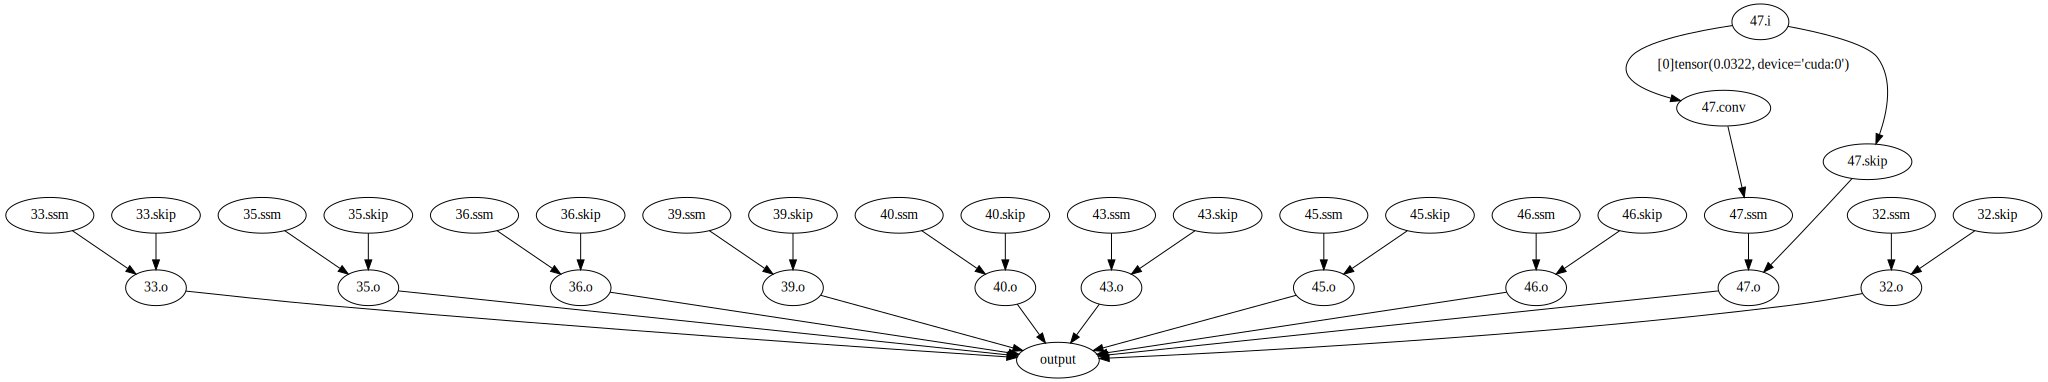

saved to checkpoint 7x5learg/checkpoint 1.pkl
patching 1056 edges, keeping 101 edges, 452 remain
patching 1056 edges, keeping 101 edges, 452 remain
baseline score 0.8453720808029175
[7] sized edge sets remaining


In [ ]:
import sys
import torch
import os
import sys
import wandb
import os
import signal
import acdc
from tqdm import tqdm
from typing import Any  
from transformer_lens.hook_points import HookPoint
from acdc import (
    Edge,
    ACDCConfig,
    LOG_LEVEL_INFO,
    LOG_LEVEL_DEBUG,
    run_acdc,
    ACDCEvalData,
    load_checkpoint,
    get_most_recent_checkpoint
)


from acdc import get_pad_token

from functools import partial


global storage
def storage_hook(
    x,
    hook: HookPoint,
    **kwargs,
):
    global storage
    #if hook.name == 'hook_embed':
    #    for k in list(storage.keys()):
    #        del storage[k]
    storage[hook.name] = x
    return x

def resid_patching_hook(
    x,
    hook: HookPoint,
    input_hook_name: str,
    batch_start: int,
    batch_end: int,
    position: int = None,
):
    global storage
    x_uncorrupted = storage[input_hook_name][batch_start:batch_end:2]
    x_corrupted = storage[input_hook_name][batch_start+1:batch_end:2]
    if position is None: # if position not specified, apply to all positions
        x[batch_start:batch_end:2] = x[batch_start:batch_end:2] - x_uncorrupted + x_corrupted
    else:
        x[batch_start:batch_end:2,position] = x[batch_start:batch_end:2,position] - x_uncorrupted[:,position] + x_corrupted[:,position]
    return x

def overwrite_patching_hook(
    x,
    hook: HookPoint,
    input_hook_name: str,
    batch_start: int,
    batch_end: int,
    position: int = None,
):
    x_corrupted = x[batch_start+1:batch_end:2]
    if position is None: # if position not specified, apply to all positions
        x[batch_start:batch_end:2] = x_corrupted
    else:
        if x_corrupted.size()[1] != L: raise ValueError(f'warning: in hook {hook.name} with input_hook_name {input_hook_name} you are patching on position in the second index but size is {x_corrupted.size()}')
        x[batch_start:batch_end:2,position] = x_corrupted[:,position]
    return x


def overwrite_h_hook(
    x,
    hook: HookPoint,
    input_hook_name: str,
    batch_start: int,
    batch_end: int,
    position: int = None,
):
    x[batch_start:batch_end:2] = x[batch_start+1:batch_end:2]
    return x

# we do a hacky thing where this first hook clears the global storage
# second hook stores all the hooks
# then third hook computes the output (over all the hooks)
# this avoids recomputing and so is much faster
CONV_HOOKS = "conv hooks"
CONV_BATCHES = "conv batches"
def conv_patching_init_hook(
    x,
    hook: HookPoint,
    batch_start: int,
    batch_end: int,
    **kwargs
):
    # we need to clear this here
    # i tried having a "current layer" variable in the conv_storage that only clears when it doesn't match
    # but that doesn't work if you only patch the same layer over and over,
    # as stuff gets carried over
    # this way of doing things is much safer and lets us assume it'll be empty
    # well not quite, note that conv_patching_hook will be called with different batch_start and batch_end inputs during one forward pass
    # so we need to account for that in the keys we use
    global conv_storage
    conv_storage = {CONV_BATCHES: set()}
    return x

# hook h has a weird index!!!!!

def conv_patching_storage_hook(
    x,
    hook: HookPoint,
    conv_filter_i: int,
    position: int,
    layer: int,
    batch_start: int,
    batch_end: int,
    **kwargs,
):
    global storage
    storage[hook.name] = x
    global conv_storage
    hooks_key = (CONV_HOOKS, batch_start, batch_end)
    if not hooks_key in conv_storage:
        conv_storage[hooks_key] = [] # we can't do this above because it'll be emptied again on the next batch before this is called
    conv_storage[hooks_key].append({"position": position, "conv_filter_i": conv_filter_i})
    conv_storage[CONV_BATCHES].add((batch_start, batch_end))
    return x

from jaxtyping import Float
from einops import rearrange


global storage_for_grad

global conv_storage
def conv_patching_hook(
    conv_output: Float[torch.Tensor, "B L E"],
    hook: HookPoint,
    input_hook_name: str,
    layer: int,
    **kwargs,
) -> Float[torch.Tensor, "B L E"]:
    global conv_storage
    global storage
    ### This is identical to what the conv is doing
    # but we break it apart so we can patch on individual filters

    # we have two input hooks, the second one is the one we want
    input_hook_name = input_hook_name[1]
    
    D_CONV = model.cfg.d_conv

    # given batches like [(2,4), (5,6)] and total size 7 this returns (0,2), (4,5), (6,7) 
    def get_missing_batches(batches, B):
        covered_i = torch.zeros([B])
        for batch_start, batch_end in batches:
            covered_i[batch_start:batch_end] = 1
    
        missing_batches = []
        missing_start = 0
        for i in range(B):
            if covered_i[i] == 1:
                if i != missing_start:
                    missing_batches.append((missing_start, i))
                missing_start = i+1
        if covered_i[B-1] == 0:
            missing_batches.append((missing_start, B))
        return missing_batches
    

    
    # [E,1,D_CONV]
    conv_weight = model.blocks[layer].conv1d.weight
    # [E]
    conv_bias = model.blocks[layer].conv1d.bias
    
    # don't recompute these if we don't need to
    # because we stored all the hooks and batches in conv_storage, we can just do them all at once
    output_key = f'output' # they need to share an output because they write to the same output tensor
    if not output_key in conv_storage:
        #print("layer", layer, "keys", conv_storage)
        apply_to_all_hooks = [] # this is important because otherwise the [0:None] would overwrite the previous results (or vice versa)
        apply_to_all_key = (CONV_HOOKS, 0, None)
        if apply_to_all_key in conv_storage:
            apply_to_all_hooks = conv_storage[apply_to_all_key]
            # we need to do this so it applies to the other batches that we aren't otherwise patching
            for batch_start, batch_end in get_missing_batches(conv_storage[CONV_BATCHES], conv_output.size()[0]):
                conv_storage[CONV_BATCHES].add(batch_start, batch_end)
                conv_storage[(CONV_HOOKS, batch_start, batch_end)] = []
        for batch_start, batch_end in conv_storage[CONV_BATCHES]:
            if batch_start == 0 and batch_end == None: continue # we cover this in the apply to all hooks above
            def get_filter_key(i):
                return f'filter_{i}'
            conv_input_uncorrupted = storage[input_hook_name][batch_start:batch_end:2]
            conv_input_corrupted = storage[input_hook_name][batch_start+1:batch_end:2]
            B, L, E = conv_input_uncorrupted.size()
            
            conv_input_uncorrupted = rearrange(conv_input_uncorrupted, 'B L E -> B E L')
            conv_input_corrupted = rearrange(conv_input_corrupted, 'B L E -> B E L')
            
            # pad zeros in front
            # [B,E,D_CONV-1+L]
            padded_input_uncorrupted = torch.nn.functional.pad(conv_input_uncorrupted, (D_CONV-1,0), mode='constant', value=0)
            padded_input_corrupted = torch.nn.functional.pad(conv_input_corrupted, (D_CONV-1,0), mode='constant', value=0)
    
            # compute the initial filter values
            for i in range(D_CONV):
                filter_key = get_filter_key(i)
                # [B,E,L]                      [E,1]                      [B,E,L]
                filter_contribution = conv_weight[:,0,i].view(E,1)*padded_input_uncorrupted[:,:,i:i+L]
                conv_storage[filter_key] = filter_contribution
            
            # apply all the hooks
            for hook in conv_storage[(CONV_HOOKS, batch_start, batch_end)] + apply_to_all_hooks:
                position = hook['position']
                conv_filter_i = hook['conv_filter_i']
                #print(f"position {position} conv_filter_i {conv_filter_i} batch_start {batch_start} batch_end {batch_end}")
                filter_key = get_filter_key(conv_filter_i)
                # [1,E,L]                                   [E,1]                          # [B,E,L]
                corrupted_filter_contribution = conv_weight[:,0,conv_filter_i].view(E,1)*padded_input_corrupted[:,:,conv_filter_i:conv_filter_i+L]
                filter_contribution = conv_storage[filter_key]
                if position is None:
                    # [B,E,L]                    [B,E,L]
                    filter_contribution = corrupted_filter_contribution
                else:
                    # [B,E]                                                  [B,E]
                    filter_contribution[:,:,position] = corrupted_filter_contribution[:,:,position]
                conv_storage[filter_key] = filter_contribution
            
            # compute the output
            output = sum([conv_storage[get_filter_key(i)] for i in range(D_CONV)])
            #output = torch.zeros([B,E,L], device=model.cfg.device)
            #print(f'B {B} B2 {B2} E {E} L {L} conv_storage keys {conv_storage.keys()} filter sizes {[(k,v.size()) for (k,v) in conv_storage.items() if not type(v) is int]}')
            for i in range(D_CONV):
                filter_key = get_filter_key(i)
                #output += conv_storage[filter_key]
                del conv_storage[filter_key] # clean up now we are done with it, just to be safe
                
            # bias is not dependent on input so no reason to patch on it, just apply it as normal
            output += conv_bias.view(E, 1)
            output = rearrange(output, 'B E L -> B L E')
            # interleave it back with the corrupted as every other
            conv_output[batch_start:batch_end:2] = output
        conv_storage[output_key] = conv_output
    return conv_storage[output_key]


limited_layers = list(range(model.cfg.n_layers))


from acdc.data.ioi import ioi_data_generator, ABC_TEMPLATES, get_all_single_name_abc_patching_formats
from acdc.data.utils import generate_dataset

num_patching_pairs = 200
seed = 27
valid_seed = 28
constrain_to_answers = True
# this makes our data size 800, first 400 is each (a,b) pair, and then second 400 is each pair swapped to be (b,a)
has_symmetric_patching = True

from acdc.data.ioi import BABA_TEMPLATES
templates = ABC_TEMPLATES
patching_formats = list(get_all_single_name_abc_patching_formats())

# generate data once to populate good_names and good_nouns (holds single-token choices)
data = generate_dataset(model=model,
                  data_generator=ioi_data_generator,
                  num_patching_pairs=num_patching_pairs,
                  seed=seed,
                  valid_seed=valid_seed,
                  constrain_to_answers=constrain_to_answers,
                  has_symmetric_patching=has_symmetric_patching, 
                  varying_data_lengths=True,
                  templates=templates,
                  patching_formats=patching_formats)

import acdc.data.ioi
from collections import defaultdict
name_positions_map = defaultdict(lambda: [])
for template in templates:
    name = acdc.data.ioi.good_names[0]
    template_filled_in = template.replace("[NAME]", name)
    template_filled_in = template_filled_in.replace("[PLACE]", acdc.data.ioi.good_nouns['[PLACE]'][0])
    template_filled_in = template_filled_in.replace("[OBJECT]", acdc.data.ioi.good_nouns['[OBJECT]'][0])
    # get the token positions of the [NAME] in the prompt
    name_positions = tuple([(i) for (i,s) in enumerate(model.to_str_tokens(torch.tensor(model.tokenizer.encode(template_filled_in)))) if s == f' {name}'])
    name_positions_map[name_positions].append(template)
sorted_by_frequency = sorted(list(name_positions_map.items()), key=lambda x: -len(x[1]))
most_frequent_name_positions, templates = sorted_by_frequency[0]
print("using templates")
for template in templates:
    print(template)
print(f"with name positions {most_frequent_name_positions}")

data = generate_dataset(model=model,
              data_generator=ioi_data_generator,
              num_patching_pairs=num_patching_pairs,
              seed=seed,
              valid_seed=valid_seed,
              constrain_to_answers=constrain_to_answers,
              has_symmetric_patching=has_symmetric_patching, 
              varying_data_lengths=True,
              templates=templates,
              patching_formats=patching_formats)


## Setup edges for ACDC
edges = []
B,L = data.data.size()
#positions = list(range(L)) # 
positions = [None]

INPUT_HOOK = f'hook_embed'
INPUT_NODE = 'embed'

last_layer = model.cfg.n_layers-1
OUTPUT_HOOK = f'blocks.{last_layer}.hook_resid_post'
OUTPUT_NODE = 'output'

def input(layer):
    return f'{layer}.i'

def output(layer):
    return f'{layer}.o'

def conv(layer):
    return f'{layer}.conv'

def skip(layer):
    return f'{layer}.skip'

def ssm(layer):
    return f'{layer}.ssm'

# important to have storage be global and not passed into the hooks! Otherwise it gets very slow (tbh, i don't know why)
global storage
storage = {}

for pos in positions:
    # direct connections from embed to output
    edges.append(Edge(
            label=str(pos),
            input_node=INPUT_NODE,
            input_hook=(INPUT_HOOK, storage_hook),
            output_node=OUTPUT_NODE,
            output_hook=(OUTPUT_HOOK, partial(resid_patching_hook, position=pos)),
    ))

for layer in limited_layers:
    for pos_i, pos in enumerate(positions):
        # edge from embed to layer input
        edges.append(Edge(
                label=str(pos),
                input_node=INPUT_NODE,
                input_hook=(INPUT_HOOK, partial(storage_hook)),
                output_node=input(layer),
                output_hook=(f'blocks.{layer}.hook_layer_input', partial(resid_patching_hook, position=pos)),
        ))

        # input to conv
        for conv_i in range(model.cfg.d_conv):
            edges.append(Edge(
                    label=(f'[{pos}:{conv_i-model.cfg.d_conv+1}]'.replace("None:", "")), # [-D_CONV+1, -D_CONV+2, ..., -2, -1, 0]
                    input_node=input(layer),
                    input_hook=[
                        (f'blocks.{layer}.hook_layer_input', conv_patching_init_hook),
                        (f'blocks.{layer}.hook_in_proj', partial(conv_patching_storage_hook, position=pos, layer=layer, conv_filter_i=conv_i))
                    ],
                    output_node=conv(layer),
                    output_hook=(f'blocks.{layer}.hook_conv', partial(conv_patching_hook, position=pos, layer=layer, conv_filter_i=conv_i)),
            ))
        
        # conv to ssm
        if pos is None:
            # we need a seperate hook for each pos, but put them all into one edge
            hooks = []
            for other_pos in range(L):
                hooks.append((f'blocks.{layer}.hook_h.{other_pos}', overwrite_h_hook))
            edges.append(Edge(
                    input_node=conv(layer),
                    output_node=ssm(layer),
                    output_hook=hooks,
            ))
        else:
            edges.append(Edge(
                    label=f'{pos}',
                    input_node=conv(layer),
                    output_node=ssm(layer),
                    output_hook=(f'blocks.{layer}.hook_h.{pos}', overwrite_h_hook),
            ))

        if pos_i == 0: # we only need one of these
            # ssm to output
            edges.append(Edge(
                    input_node=ssm(layer),
                    output_node=output(layer),
            ))
        
        # input to skip
        edges.append(Edge(
                label=f'{pos}',
                input_node=input(layer),
                output_node=skip(layer),
                output_hook=(f'blocks.{layer}.hook_skip', partial(overwrite_patching_hook, position=pos)),
        ))

        if pos_i == 0: # we only need one of these
            # skip to output
            edges.append(Edge(
                    input_node=skip(layer),
                    output_node=output(layer),
            ))
        
        for later_layer in limited_layers:
                if layer < later_layer:
                    # edge from layer output to other layer input
                    edges.append(Edge(
                            label=str(pos),
                            input_node=output(layer),
                            input_hook=(f'blocks.{layer}.hook_out_proj', storage_hook),
                            output_node=input(later_layer),
                            output_hook=(f'blocks.{later_layer}.hook_layer_input', partial(resid_patching_hook, position=pos)),
                    ))
        
        # edge from layer output to final layer output
        edges.append(Edge(
                label=str(pos),
                input_node=output(layer),
                input_hook=(f'blocks.{layer}.hook_out_proj', storage_hook),
                output_node=OUTPUT_NODE,
                output_hook=(OUTPUT_HOOK, partial(resid_patching_hook, position=pos)),
        ))

# we have edges between layers
# now, that is edges between output(input_layer) and input(output_layer)
# we can then allow pruning to remove stranded nodes

keeping_edges = set()
for score, (input_layer, output_layer, pos) in pruned_edges:
    keeping_edges.add((str(input_layer), str(output_layer)))

print(sorted(list(keeping_edges)))

totes_keep = []
for edge in edges:
    is_between_layers = False
    layer_input = None
    layer_output = None
    if edge.input_node == INPUT_NODE:
        is_between_layers = True
        layer_input = 'embed'
    if edge.output_node == OUTPUT_NODE:
        is_between_layers = True
        layer_output = 'output'

    if '.' in edge.input_node:
        input_layer, input_type = edge.input_node.split(".")
        if edge.input_node == output(input_layer):
            is_between_layers = True
            layer_input = str(input_layer)
    if '.' in edge.output_node:
        output_layer, output_type = edge.output_node.split(".")
        if edge.output_node == input(output_layer):
            is_between_layers = True
            layer_output = str(output_layer)
    if is_between_layers:
        if (layer_input, layer_output) in keeping_edges:
            edge.patching = False
            edge.checked = False
            totes_keep.append((edge.input_node, edge.output_node))
        else:
            edge.patching = True
            edge.checked = True
    else:
        edge.patching = False
        edge.checked = False

print(list(sorted(totes_keep)))

model_kwargs = {
    'fast_ssm': False,
    'fast_conv': False,
}    

def normalized_logit_diff_acdc_metric(data: ACDCEvalData, printing=False):
    B,V = data.patched.logits.size()

    # [batch_size]
    patched_correct = data.patched.correct[:,0]
    #print(data.unpatched.logits.size(), data.patched.logits.size(), data.corrupted.logits.size())
    A_logits_unpatched = data.unpatched.logits[torch.arange(B), patched_correct]
    A_logits_patched = data.patched.logits[torch.arange(B), patched_correct]
    A_logits_corrupted = data.corrupted.logits[torch.arange(B), patched_correct]

    corrupted_correct = data.corrupted.correct[:,0]
    B_logits_unpatched = data.unpatched.logits[torch.arange(B), corrupted_correct]
    B_logits_patched = data.patched.logits[torch.arange(B), corrupted_correct]
    B_logits_corrupted = data.corrupted.logits[torch.arange(B), corrupted_correct]

    # A and B are two potential outputs
    # if A patched > B patched, we are correct
    # else we are incorrect

    # thus we could just return A_logits_patched - B_logits_patched

    # however it is useful to "normalize" these values

    # in the worst case, our patching causes us to act like corrupted, and our diff will be
    # A_logits_corrupted - B_logits_corrupted
    # this will result in a small, negative value
    
    # in the best case, our patching will do nothing (cause us to act like unpatched), and our diff will be
    # A_logits_unpatched - B_logits_unpatched
    # this will result in a large, positive value

    # thus we can treat those as the "min" and "max" and normalize accordingly
    
    min_diff = A_logits_corrupted - B_logits_corrupted
    max_diff = A_logits_unpatched - B_logits_unpatched

    possible_range = (max_diff-min_diff)
    possible_range[possible_range == 0] = 1.0 # prevent divide by zero
    
    diff = A_logits_patched - B_logits_patched
    normalized_diff = (diff-min_diff)/torch.abs(possible_range) # abs prevents incorrect data from wanting to be more incorrect

    if printing:
        print(f"A corrupted {A_logits_corrupted}")
        print(f"B corrupted {B_logits_corrupted}")
        print(f"A unpatched {A_logits_unpatched}")
        print(f"B unpatched {B_logits_unpatched}")
        print(f"A patched {A_logits_patched}")
        print(f"B patched {B_logits_patched}")
        print(f"min diff {min_diff}")
        print(f"max diff {max_diff}")
        print(f"possible range {possible_range}")
        print(f"diff {diff}")
        print(f"normalized diff {normalized_diff}")
    # as described, 1.0 corresponds to acting like unpatched,
    # and 0.0 corresponds to acting like corrupted

    return torch.mean(normalized_diff)

wandb.finish()
job_name_text = 'mamba acdc not positional' + ".txt"
wandb.login()
acdc.tqdm = tqdm

if os.path.exists(job_name_text):
    with open(job_name_text, "r") as f:
        wandb_id = f.read().strip()
    print(f"resuming from {wandb_id}")
    resume = True
else:
    wandb_id = wandb.util.generate_id()
    with open(job_name_text, "w") as f:
        f.write(wandb_id)
    print(f"starting new run {wandb_id}")
    resume = False



from functools import partial
import acdc

cfg = ACDCConfig(
    ckpt_directory = wandb_id,
    thresh = 0.0001,
    rollback_thresh = 0.0001,
    metric=normalized_logit_diff_acdc_metric,
    # extra inference args
    model_kwargs=model_kwargs,
    # these are needed for doing graph pruning
    input_node=INPUT_NODE,
    output_node=OUTPUT_NODE,
    # batch size for evaluating data points
    batch_size=1,
    log_level=LOG_LEVEL_INFO,
    # if False, will be equivalent to batch_size=1
    batched = True,
    # set these two to false to use traditional ACDC
    # recursive will try patching multiple at a time (this is faster sometimes)
    recursive = True,
    # try_patching_multiple_at_same_time will evaluate many different patchings before commiting to any
    # and includes a rollback scheme if after patching one, the others get worse
    try_patching_multiple_at_same_time = True,
    ## if true, you metric will also have the logits from a run with no patching available
    # (useful for normalized logit diff)
    store_unpatched_logits = True,
)

wandb_resume = None
if resume:
    try:
        most_recent_checkpoint_path, is_done = get_most_recent_checkpoint(checkpoint_dir=cfg.ckpt_directory)
        if is_done:
            print(f"run {cfg.ckpt_directory} is completed")
        else:
            print(f"resuming from checkpoint {most_recent_checkpoint_path}")
            old_cfg, edges = load_checkpoint(path=most_recent_checkpoint_path)
            cfg.iter = old_cfg.iter
            wandb_resume = 'must'
    except FileNotFoundError:
        print(f"no checkpoints available at {cfg.ckpt_directory}, starting from scratch")
class InterruptedException(Exception):
    pass

def interrupt_callback(sig_num: Any, stack_frame: Any):
    raise InterruptedException()
wandb.finish()
try:
    wandb.init(
        project="mamba-acdc",
        config=cfg,
        name=job_name_text.replace(".txt", "") + f' thresh={cfg.thresh} rollback_thresh={cfg.rollback_thresh}',
        resume=wandb_resume,
        id=wandb_id,
    )
    # signal handlers (if preempted)
    signal.signal(signal.SIGINT, interrupt_callback)
    signal.signal(signal.SIGTERM, interrupt_callback)
    result_edges = run_acdc(model=model, data=data, cfg=cfg, edges=edges)
except (KeyboardInterrupt, InterruptedException):
    print("interrupted")

# Display ACDC Results

got L of 20
testing 0->1 True True
testing 0->3 True False
pruning 3 0->3 True False
testing 0->7 True True
testing 0->8 True True
testing 0->10 True True
testing 0->11 True True
testing 0->12 True True
testing 0->13 True True
testing 0->14 True True
testing 0->15 True True
testing 0->16 True True
testing 0->17 True True
testing 0->18 True True
testing 0->19 True True
testing 0->20 True True
testing 0->21 True True
testing 0->23 True True
testing 0->25 True True
testing 0->36 True True
testing 0->40 True True
testing 0->41 True True
testing 1->4 True True
testing 1->7 True True
testing 1->8 True True
testing 1->11 True True
testing 1->12 True True
testing 1->13 True True
testing 1->14 True True
testing 1->15 True True
testing 1->16 True True
testing 1->17 True True
testing 1->18 True True
testing 1->19 True True
testing 1->20 True True
testing 1->21 True True
testing 1->22 True True
testing 1->23 True True
testing 1->24 True True
testing 1->25 True True
testing 1->26 True True
testing 

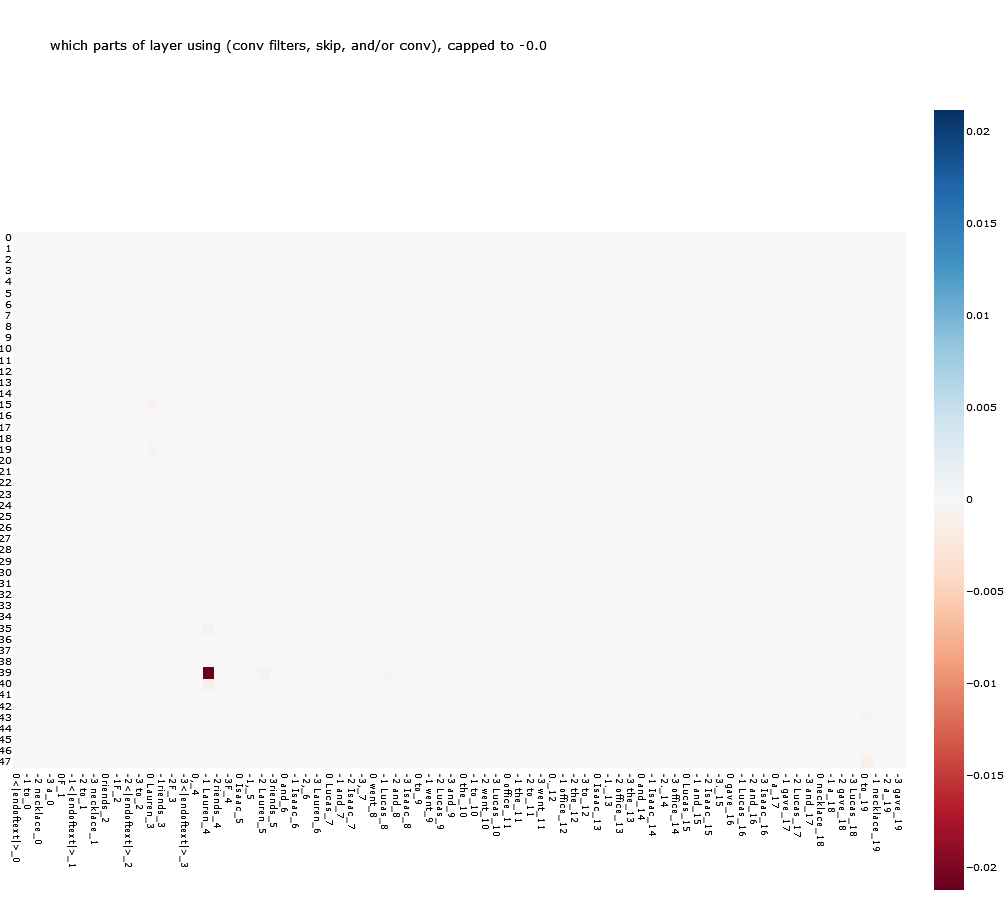

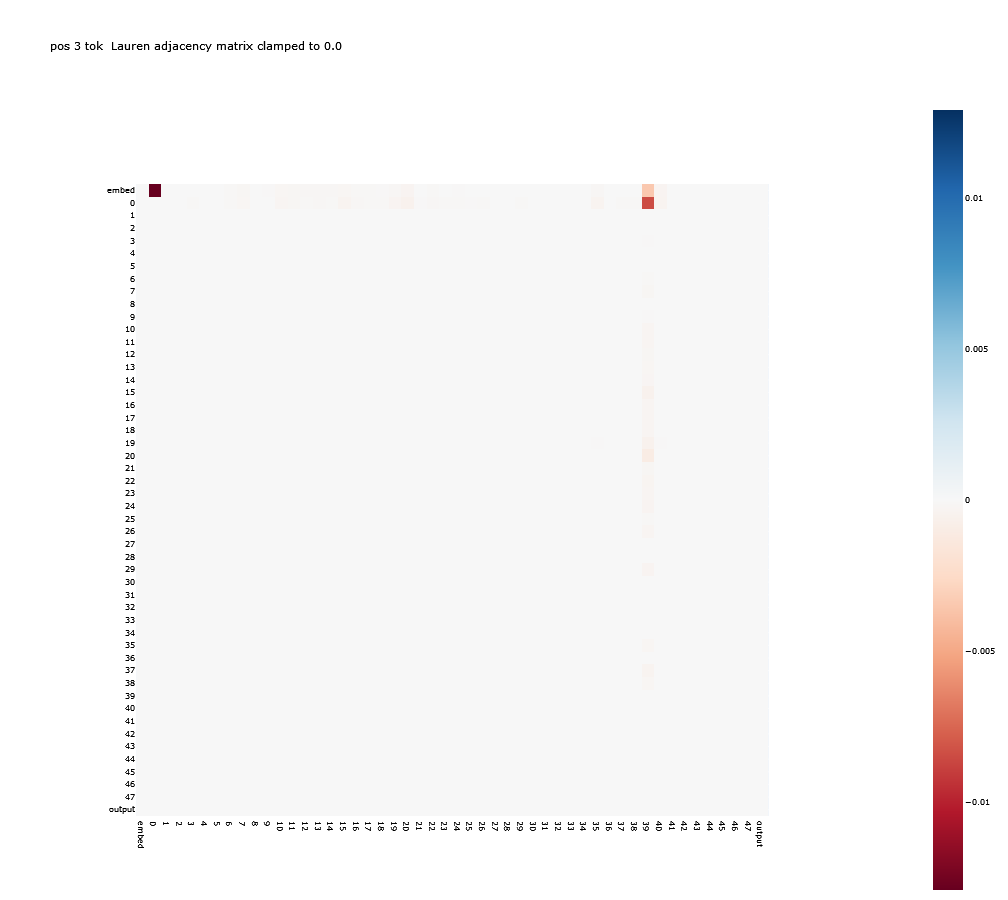

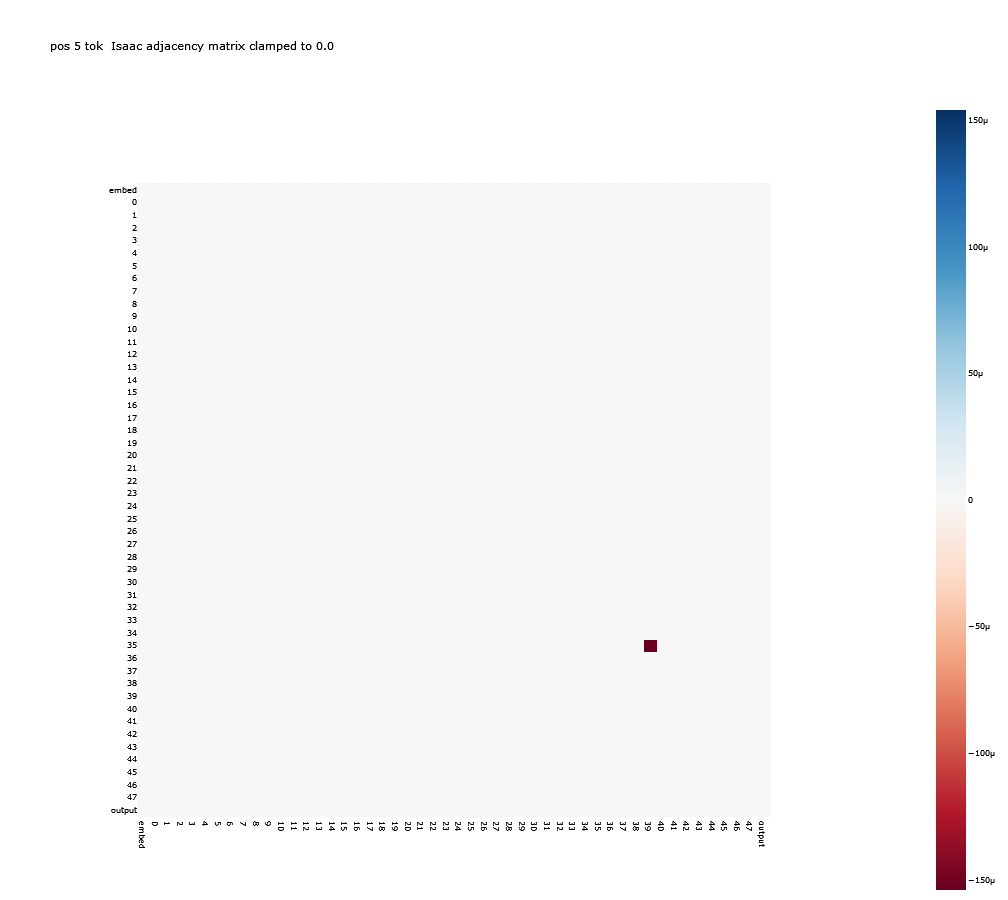

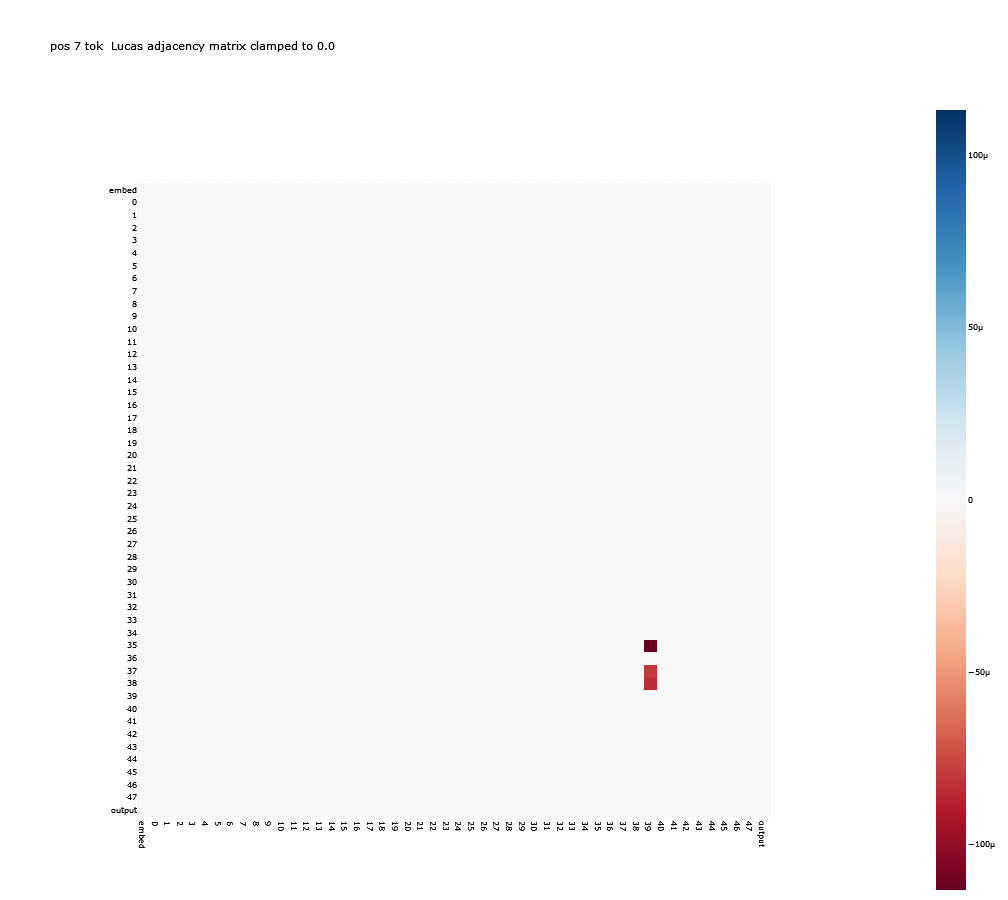

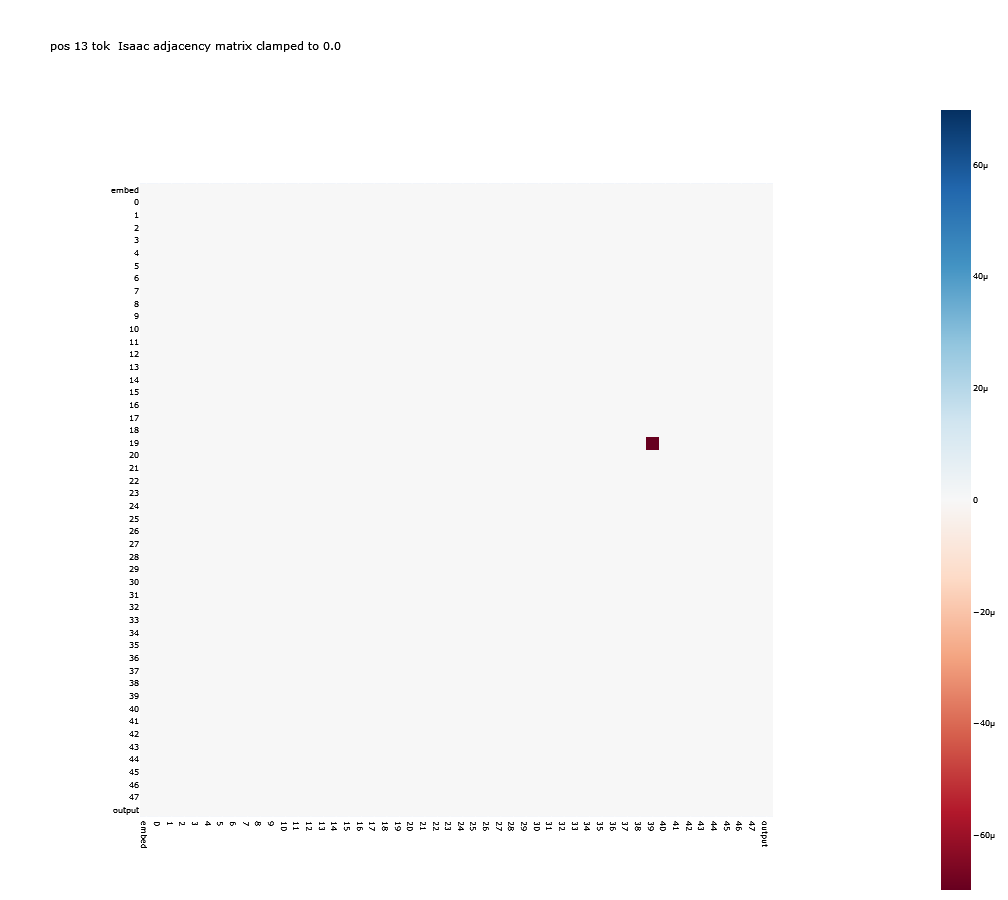

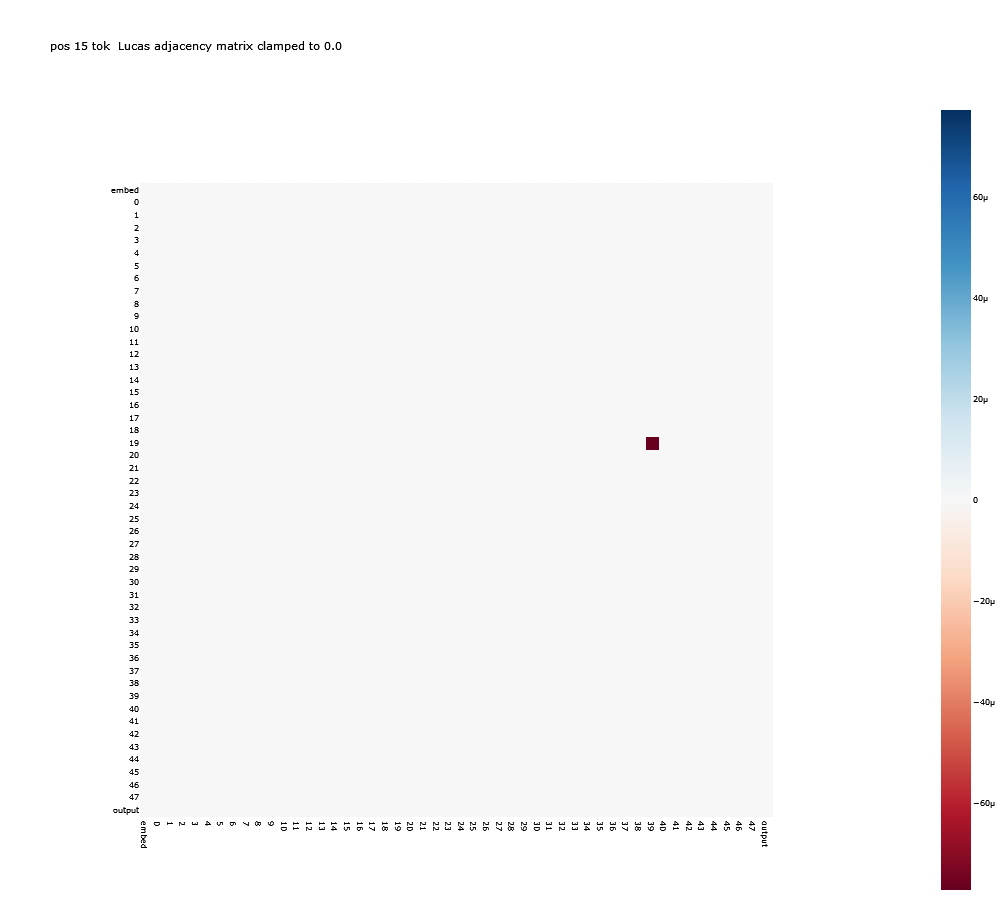

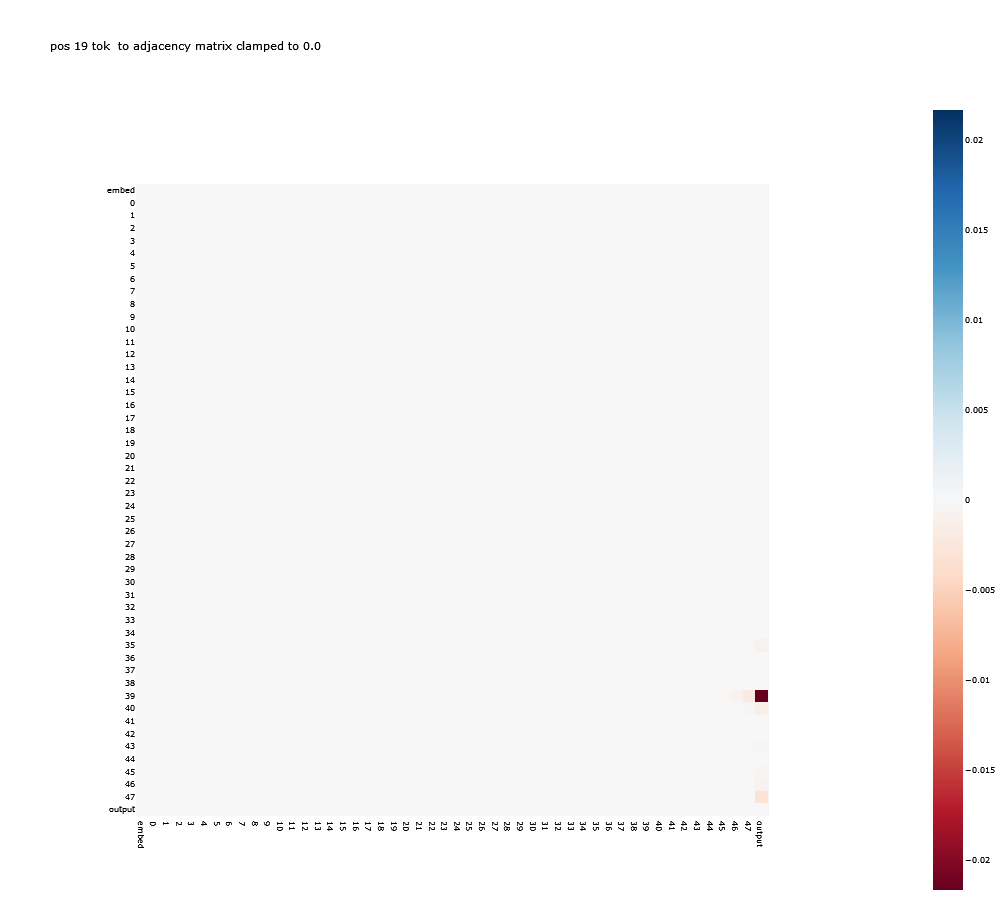

In [216]:
from acdc import ACDCEvalData
from transformer_lens.hook_points import HookPoint
import torch
from IPython.display import display, FileLink, Image
import acdc
from importlib import reload
edges = edges_to_keep
L = data.data.size()[1]
print(f"got L of {L}")
if POSITIONS:
    by_filters = torch.zeros([model.cfg.d_conv*L, model.cfg.n_layers])
else:
    by_filters = torch.zeros([model.cfg.d_conv, model.cfg.n_layers])

# change this to get the different plots
CAP = 0.0
# 1.0 is boolean (present or not)
# 0.0 is just give score

def filter_score(score):
    if CAP == 0.0: return score
    if CAP == 1.0: return 1.0
    return max(score, -CAP)
for edge in edges:
    if not edge.patching and edge.checked:
        if '.conv' in edge.output_node:
            if ":" in edge.label:
                pos = int(edge.label.split(":")[0][1:])
                rest = edge.label.split(":")[1]
            else:
                pos = None
                rest = edge.label[1:]
            filter = int(rest.split("]")[0])        
            layer = edge.output_node.split(".")[0]
            if POSITIONS:
                try:
                    by_filters[model.cfg.d_conv*pos + abs(int(filter)),int(layer)] = filter_score(edge.score_diff_when_patched)
                except:
                    print(L, pos, abs(int(filter)))
                    raise
            else:
                by_filters[abs(int(filter)),int(layer)] = filter_score(edge.score_diff_when_patched)
        if '.skip' in edge.output_node and False:        
            layer = edge.output_node.split(".")[0]
            by_filters[model.cfg.d_conv,int(layer)] = filter_score(edge.score_diff_when_patched)
        if '.ssm' in edge.output_node and False:
            layer = edge.output_node.split(".")[0]
            by_filters[model.cfg.d_conv+1,int(layer)] = filter_score(edge.score_diff_when_patched)
            

def layer_to_i(node):
    if node == INPUT_NODE:
        return 0
    elif node == OUTPUT_NODE:
        return model.cfg.n_layers+1 # because embed is 0
    else:
        return int(node)+1 # because embed is 0


def between_layers_info(edge):
    if edge.patching: return False, None, None
    is_between_layers = False
    layer_input = None
    layer_output = None
    if edge.input_node == INPUT_NODE:
        is_between_layers = True
        layer_input = INPUT_NODE
    if edge.output_node == OUTPUT_NODE:
        is_between_layers = True
        layer_output = OUTPUT_NODE

    if '.' in edge.input_node:
        input_layer, input_type = edge.input_node.split(".")
        if edge.input_node == output(input_layer):
            is_between_layers = True
            layer_input = str(input_layer)
    if '.' in edge.output_node:
        output_layer, output_type = edge.output_node.split(".")
        if edge.output_node == input(output_layer):
            is_between_layers = True
            layer_output = str(output_layer)
    return is_between_layers, layer_input, layer_output

def compute_adj_mat(edges):
    if POSITIONS:
        adj_mat = torch.zeros([L, model.cfg.n_layers+2, model.cfg.n_layers+2])
    else:
        adj_mat = torch.zeros([model.cfg.n_layers+2, model.cfg.n_layers+2])
    for edge in edges:
        is_between_layers, layer_input, layer_output = between_layers_info(edge)
        if is_between_layers:
            if POSITIONS:
                pos = int(edge.label)
                adj_mat[pos, layer_to_i(layer_input), layer_to_i(layer_output)] = edge.score_diff_when_patched
            else:
                adj_mat[layer_to_i(layer_input), layer_to_i(layer_output)] = edge.score_diff_when_patched
    return adj_mat


L = data.data.size()[1]
import networkx as nx
def better_get_nx_graph(adj_mat) -> nx.DiGraph:
    '''
    Converts the edges into a networkx graph
    only edges that have checked == True and patching == False are included
    if include_unchecked=True, any edge that has checked == False is also included
    '''
    num_nodes = adj_mat.size()[-1]
    G = nx.DiGraph()
    edges = []
    if POSITIONS:
        for pos in range(L):
            for i in range(num_nodes):
                for j in range(num_nodes):
                    if adj_mat[pos,i,j] != 0:
                        G.add_edge(str(i), str(j))
                        edges.append((i,j,pos,adj_mat[pos,i,j]))
    else:
        for i in range(num_nodes):
            for j in range(num_nodes):
                if adj_mat[i,j] != 0:
                    G.add_edge(str(i), str(j))
                    edges.append((i,j,None,adj_mat[i,j]))
    return G, edges

def better_prune_edges(adj_mat):
    num_nodes = adj_mat.size()[-1]
    input_node = 0
    output_node = num_nodes-1
    import networkx as nx
    G, edges = better_get_nx_graph(adj_mat=adj_mat)
    pruned_adj_mat = torch.zeros(adj_mat.size())
    pruned_edges = []
    for i,j,pos,attr in edges:
        connected_to_input = False
        try:
            to_input = nx.shortest_path(G, source=str(input_node), target=str(i))
            connected_to_input = True
        except nx.NetworkXNoPath:
            pass
        except nx.NodeNotFound:
            raise ValueError(f"Graph does not have input node {input_node}")
        
        connected_to_output = False
        try:
            to_output = nx.shortest_path(G, source=str(j), target=str(output_node))
            connected_to_output = True
        except nx.NetworkXNoPath:
            pass
        except nx.NodeNotFound:
            raise ValueError(f"Graph does not have output node {output_node}")
        print(f"testing {i}->{j} {connected_to_input} {connected_to_output}")
        if connected_to_input and connected_to_output:
            pruned_adj_mat[pos,i,j] = attr
        else:
            print(f"pruning {pos} {i}->{j} {connected_to_input} {connected_to_output}")
    return pruned_adj_mat

adj_mat = compute_adj_mat(edges_to_keep)
pruned_adj_mat = better_prune_edges(adj_mat)

def imshow(tensor, renderer=None, xaxis="", yaxis="", font_size=None, show=True, color_continuous_midpoint=0.0, **kwargs):
    import plotly.express as px
    import transformer_lens.utils as utils
    fig = px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=color_continuous_midpoint, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs)
    if not font_size is None:
        if 'x' in kwargs and False:
            fig.update_layout(
              xaxis = dict(
                tickmode='array',
                tickvals = kwargs['x'],
                ticktext = kwargs['x'], 
                ),
               font=dict(size=font_size, color="black"))
        if 'y' in kwargs:
            fig.update_layout(
              yaxis = dict(
                tickmode='array',
                tickvals = kwargs['y'],
                ticktext = kwargs['y'], 
                ),
               font=dict(size=font_size, color="black"))
    plot_args = {
        'width': 1200,
        'height': 900,
        "autosize": False,
        'showlegend': True,
        'margin': {"l":0,"r":0,"t":100,"b":0}
    }
    
    fig.update_layout(**plot_args)
    fig.update_layout(legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    ))
    if show:
        fig.show(renderer)
    else:
        return fig

def to_str(lis):
    return [str(x) for x in lis]
x_labels = to_str([-x for x in range(model.cfg.d_conv)])
toks = model.to_str_tokens(data.data[0])
x_labels_all_pos = []
for l in range(L):
    x_labels_all_pos += [label + toks[l+int(label)] + "_" + str(l) for label in x_labels]
print(x_labels, by_filters.size())
print(len(x_labels_all_pos))
title = f'which parts of layer using (conv filters, skip, and/or conv), capped to {-CAP}'
if CAP == 1.0:
    title = f'which parts of layer using (conv filters, skip, and/or conv)'
print(x_labels_all_pos)
imshow(by_filters.T, y=to_str(range(model.cfg.n_layers)), x=x_labels_all_pos, title=title, font_size=9)
#for layer in range(model.cfg.n_layers):
#    imshow(by_filters[:,layer:layer+1].T, y=to_str([layer]), x=x_labels_all_pos, title=str(layer), font_size=9)

labels = ['embed'] + [str(x) for x in range(model.cfg.n_layers)] + ['output']
if POSITIONS:
    for position in range(L):
        if torch.any(pruned_adj_mat[position] != 0):
            imshow(pruned_adj_mat[position], y=labels, x=labels, title=f'pos {position} tok {toks[position]} adjacency matrix clamped to {CAP}', font_size=8)
else:
    imshow(pruned_adj_mat, y=labels, x=labels, title=f'adjacency matrix clamped to {CAP}', font_size=8)


In [217]:
name_positions = [3,5,7,13,15]
position_map = {}
for l in range(L):
    position_map[l] = f'pos{l}{toks[l]}'
position_map[3] = 'n1'
position_map[5] = 'n2'
position_map[7] = 'n3'
position_map[13] = 'n4'
position_map[15] = 'n5'
position_map[19] = 'out'



for layer in range(model.cfg.n_layers):
    layer_attrs = []
    for l in range(L):
        for filter_i in range(model.cfg.d_conv):
            filter_offset = -filter_i
            index = l*model.cfg.d_conv + filter_i
            attr = by_filters[index, layer]
            if attr < 0:
                layer_attrs.append((position_map[l+filter_offset], attr, filter_offset))
    print(layer)
    for tok, attr, filter_offset in layer_attrs:
        attr = -attr*1000
        print(f"  {tok}[{filter_offset}] {attr:.5f}")

def map_layer(layer):
    if layer == 0: return 'embed'
    if layer == model.cfg.n_layers+1: return 'output'
    else: return str(layer-1)

for layer in range(model.cfg.n_layers+2):
    layer_attrs = []
    for other_layer in range(model.cfg.n_layers+2):
        for pos in range(L):
            if pruned_adj_mat[pos, layer, other_layer] != 0:
                layer_attrs.append((position_map[pos], f"->{map_layer(other_layer)}", pruned_adj_mat[pos, layer, other_layer]))
            if pruned_adj_mat[pos, other_layer, layer] != 0:
                layer_attrs.append((position_map[pos], f"{map_layer(other_layer)}->", pruned_adj_mat[pos, other_layer, layer]))
    print(map_layer(layer))
    for tok, label, attr in layer_attrs:
        attr = -attr*1000
        print(f"  {tok} {label} {attr:.5f}")


0
  n1[0] 0.05820
1
2
3
  n1[-1] 0.18289
4
5
6
7
8
9
10
  n1[0] 0.12737
11
12
  n1[0] 0.10826
13
  n1[0] 0.20270
14
  n1[0] 0.14679
15
  n1[0] 0.61699
16
  n1[0] 0.07729
17
  n1[0] 0.16290
18
  n1[0] 0.14058
19
  n1[0] 0.55857
20
21
  n1[0] 0.13370
22
  n1[0] 0.10214
23
24
  n1[0] 0.14736
25
  n1[-1] 0.07483
26
  n1[0] 0.21792
  n1[-1] 0.06346
27
28
29
30
31
32
  n1[-1] 0.16530
33
34
35
  n1[-1] 1.07762
36
37
  n1[0] 0.18703
  out[0] 0.05984
38
  n1[-1] 0.09145
39
  n1[-1] 21.18783
  pos4,[-1] 0.18971
  n1[-2] 0.75065
  n2[-1] 0.07930
  pos6 and[-1] 0.12842
  n3[-1] 0.25704
  n4[-1] 0.11354
  n5[-1] 0.20464
40
  n1[-1] 1.31916
  n2[-1] 0.10377
  n3[-1] 0.07438
41
42
43
  out[0] 0.23600
44
45
  out[0] 0.09958
46
  out[0] 0.18776
47
  out[0] 1.19274
embed
  n1 ->0 12.92368
  n1 ->6 0.13451
  n1 ->7 0.19051
  n1 ->9 0.06071
  n1 ->10 0.22672
  n1 ->11 0.19091
  n1 ->12 0.18082
  n1 ->13 0.15283
  n1 ->14 0.14893
  n1 ->15 0.22828
  n1 ->16 0.12191
  n1 ->17 0.13026
  n1 ->18 0.07882
  n1 

testing 0->1 True True
testing 0->3 True False
pruning 3 0->3 True False
testing 0->7 True True
testing 0->8 True True
testing 0->10 True True
testing 0->11 True True
testing 0->12 True True
testing 0->13 True True
testing 0->14 True True
testing 0->15 True True
testing 0->16 True True
testing 0->17 True True
testing 0->18 True True
testing 0->19 True True
testing 0->20 True True
testing 0->21 True True
testing 0->23 True True
testing 0->25 True True
testing 0->36 True True
testing 0->40 True True
testing 0->41 True True
testing 1->4 True True
testing 1->7 True True
testing 1->8 True True
testing 1->11 True True
testing 1->12 True True
testing 1->13 True True
testing 1->14 True True
testing 1->15 True True
testing 1->16 True True
testing 1->17 True True
testing 1->18 True True
testing 1->19 True True
testing 1->20 True True
testing 1->21 True True
testing 1->22 True True
testing 1->23 True True
testing 1->24 True True
testing 1->25 True True
testing 1->26 True True
testing 1->27 True T

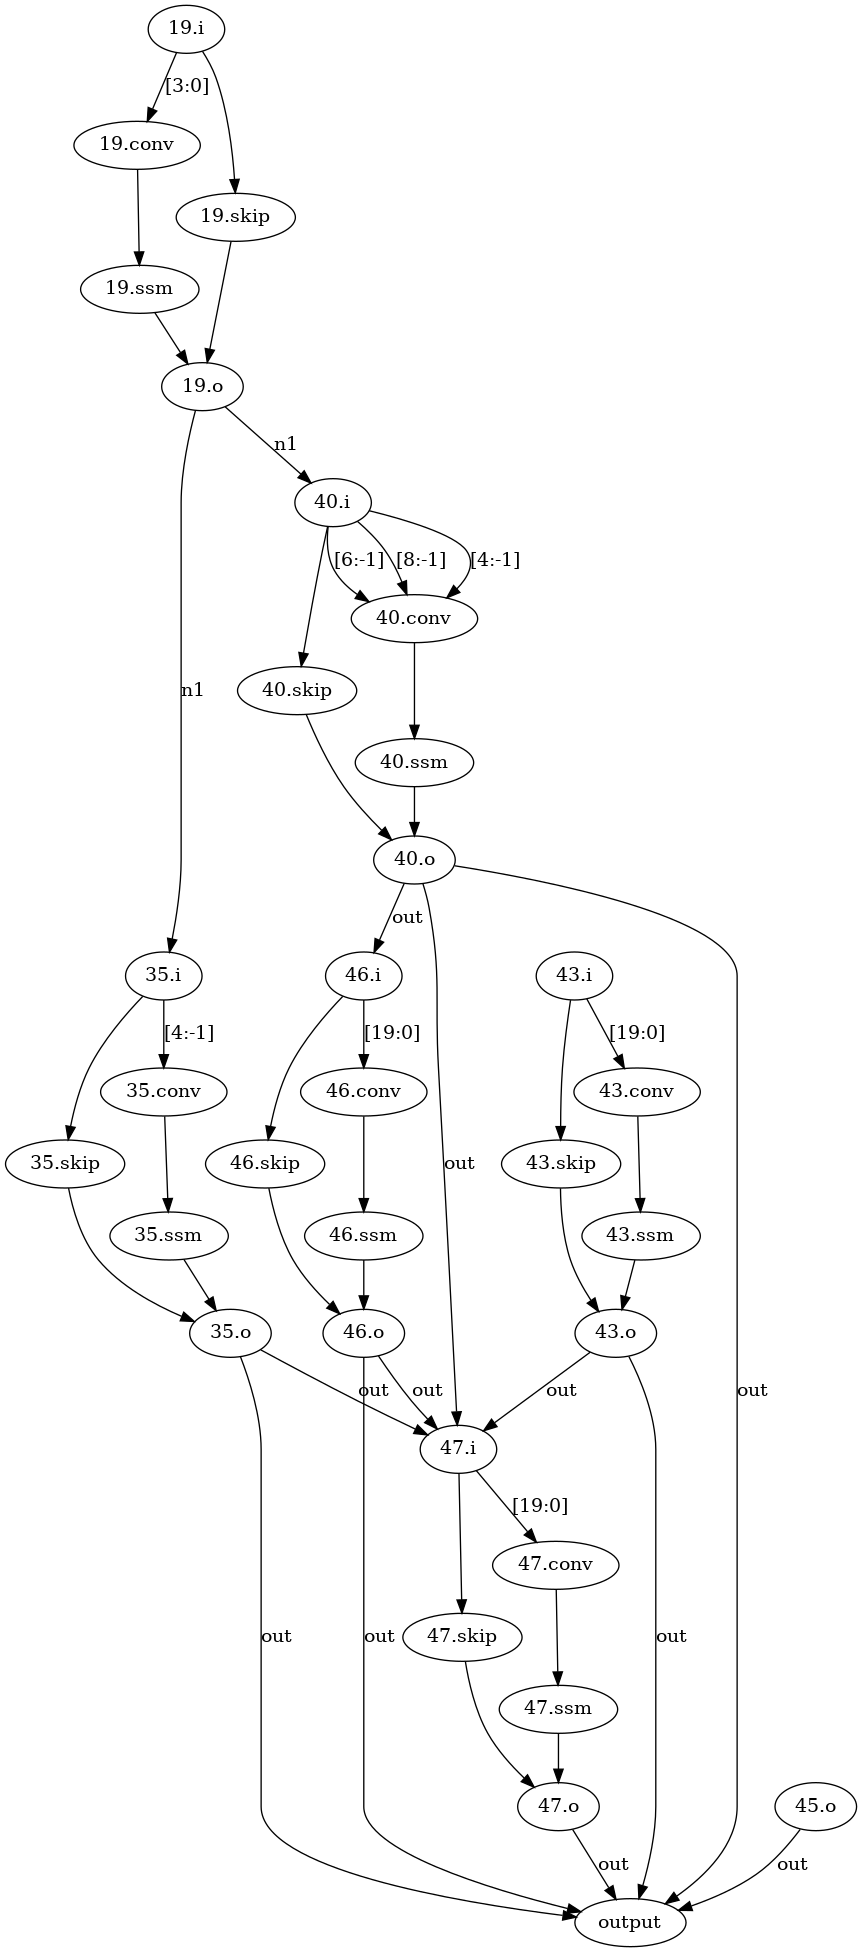

/home/dev/mamba_interp/pruned dot 0.85.png

In [218]:

def layer_to_i(layer):
    if layer == 'embed': return 0
    elif layer == 'output': return model.cfg.n_layers+1
    else: return int(layer)+1

forbidden = [0,1,40]
pruned_adj_mat = better_prune_edges(adj_mat)
for i in forbidden:
    pruned_adj_mat[:,i,:] = 0
    pruned_adj_mat[:,:,i] = 0
present_layers = set()
for i in range(model.cfg.n_layers):
    for j in range(model.cfg.n_layers):
        if not i+1 in forbidden and not j+1 in forbidden:
            if torch.any(pruned_adj_mat[:,i+1,j+1] != 0):
                present_layers.add(i)
                present_layers.add(j)
                #print(f"present edge {i}->{j}")
print(present_layers)
pruned_dot = graphviz.Digraph('graph')
for edge in edges_to_keep:
    is_between_layers, layer_input, layer_output = between_layers_info(edge)
    if is_between_layers:
        ini, outi = layer_to_i(layer_input), layer_to_i(layer_output)
        pos = int(edge.label)
        if pruned_adj_mat[pos, ini, outi] != 0:
            if not ini in forbidden and not outi in forbidden:
                pruned_dot.edge(edge.input_node, edge.output_node, label=position_map[int(edge.label)])
    else:
        layer = int(edge.input_node.split(".")[0])
        if layer in present_layers: # don't display stuff that are disconnected
            if '.ssm' in edge.output_node or '.skip' in edge.output_node or '.skip' in edge.input_node: # don't need all these since they are all forced on
                if edge.label == 0 or edge.label == "" or edge.label is None or edge.label == "0":
                    pruned_dot.edge(edge.input_node, edge.output_node)
            else:
                pruned_dot.edge(edge.input_node, edge.output_node, label=edge.label)
output_name = f'pruned dot {ACC_THRESH}'
pruned_dot.render(output_name, format="png") # it automatically appends png
display(Image(filename=output_name + ".png"))
display(FileLink(output_name + ".png"))

In [ ]:
1+1